# **Prepare BJTaxi Dataset**

In [ ]:
import os
import h5py
import numpy as np
import pandas as pd

below code from https://github.com/TolicWang/DeepST/blob/master/data/TaxiBJ/TaxiBJ.py

In [ ]:
def load_trajectory_data(fname):
    """
    Load only the trajectory data (crowd flow data) from the given file.
    :param fname: Path to the .h5 file.
    :return: data (crowd flow), timestamps
    """
    f = h5py.File(fname, 'r')
    data = f['data'][:]  # Access the crowd flow data (inflow/outflow)
    timestamps = f['date'][:]  # Access the timestamps for each data entry
    f.close()
    return data, timestamps

def load_dataset_only_trajectory(T=48, nb_flow=2, len_test=None):
    """
    Load only the trajectory data (crowd flow) and timestamps.
    :param T: Number of time slots per day (e.g., 48 for 30-minute intervals).
    :param nb_flow: Number of flow channels to load (e.g., 2 for inflow/outflow).
    :param len_test: Number of test samples to keep.
    :return: data_all, timestamps_all (trajectory data and corresponding timestamps)
    """
    data_all = []
    timestamps_all = []

    # Load the data for each year
    for year in range(13, 17):
        fname = os.path.join('/content/', f'BJ{year}_M32x32_T30_InOut.h5')
        print(f"Loading data from: {fname}")

        # Load only the trajectory data (inflow/outflow)
        data, timestamps = load_trajectory_data(fname)

        # Remove incomplete days (days with less than 48 timestamps)
        data, timestamps = remove_incomplete_days(data, timestamps, T)

        # Only keep the first 'nb_flow' channels (inflow and outflow)
        data = data[:, :nb_flow]

        # Ensure no negative values (if present in the dataset)
        data[data < 0] = 0.0

        data_all.append(data)
        timestamps_all.append(timestamps)

    return data_all, timestamps_all

def remove_incomplete_days(data, timestamps, T=48):
    """
    remove a certain day which has not 48 timestamps
    :param data:
    :param timestamps:
    :param T:
    :return:
    """

    days = []  # available days: some day only contain some seqs
    days_incomplete = []
    i = 0
    while i < len(timestamps):
        if int(timestamps[i][8:]) != 1:
            i += 1
        elif i + T - 1 < len(timestamps) and int(timestamps[i + T - 1][8:]) == T:
            days.append(timestamps[i][:8])
            i += T
        else:
            days_incomplete.append(timestamps[i][:8])
            i += 1
    print("incomplete days: ", days_incomplete)
    days = set(days)
    idx = []
    for i, t in enumerate(timestamps):
        if t[:8] in days:
            idx.append(i)

    data = data[idx]
    timestamps = [timestamps[i] for i in idx]
    return data, timestamps

In [ ]:
data_all, timestamps_all = load_dataset_only_trajectory(T=48, nb_flow=2, len_test=28 * 48)

# Display the first few timestamps and data shapes
print("Data shape for the first dataset: ", data_all[0].shape)
print("Timestamps for the first dataset: ", timestamps_all[0][:10])

Loading data from: /content/BJ13_M32x32_T30_InOut.h5
incomplete days:  [b'20130926']
Loading data from: /content/BJ14_M32x32_T30_InOut.h5
incomplete days:  [b'20140304', b'20140313', b'20140323', b'20140326', b'20140401', b'20140402', b'20140409', b'20140410', b'20140412', b'20140422', b'20140501', b'20140526', b'20140618', b'20140627']
Loading data from: /content/BJ15_M32x32_T30_InOut.h5
incomplete days:  [b'20150320', b'20150404', b'20150620']
Loading data from: /content/BJ16_M32x32_T30_InOut.h5
incomplete days:  [b'20151101', b'20151103', b'20151109', b'20151110', b'20151112', b'20151121', b'20151124', b'20151128', b'20151201', b'20151203', b'20151206', b'20151210', b'20151211', b'20151212', b'20151217', b'20151227', b'20151229', b'20160111', b'20160127', b'20160323', b'20160410']
Data shape for the first dataset:  (4848, 2, 32, 32)
Timestamps for the first dataset:  [b'2013070101', b'2013070102', b'2013070103', b'2013070104', b'2013070105', b'2013070106', b'2013070107', b'201307010

In [ ]:
# Extract inflow and outflow matrices for the chosen time step
# data_all has shape (4,4848, 2, 32, 32)
inflow_matrix = data_all[0][0][0]  # Inflow (first dataset, first time, first channel)
outflow_matrix = data_all[0][0][1]  # Outflow (first dataset,first time, second channel)

In [ ]:
print(inflow_matrix.shape)
print(inflow_matrix)

(32, 32)
[[  0.  20.  41. ...   7.   1.  40.]
 [  0.  11.   8. ...  22.   7.  96.]
 [  0.   9.   5. ...  14. 198. 117.]
 ...
 [  1.   3.   4. ...   8.   6.   3.]
 [  0.   0.   0. ...   9.   0.   7.]
 [  1.   0.   0. ...  17.  20.   7.]]


In [ ]:
print(outflow_matrix.shape)
print(outflow_matrix)

(32, 32)
[[  0.  21.  44. ...   6.   1.  38.]
 [  0.  11.   8. ...  23.   6.  93.]
 [  0.   9.   5. ...  15. 201. 120.]
 ...
 [  2.   3.   4. ...   7.   7.   3.]
 [  0.   0.   0. ...   9.   0.   7.]
 [  1.   0.   0. ...  19.  21.   8.]]


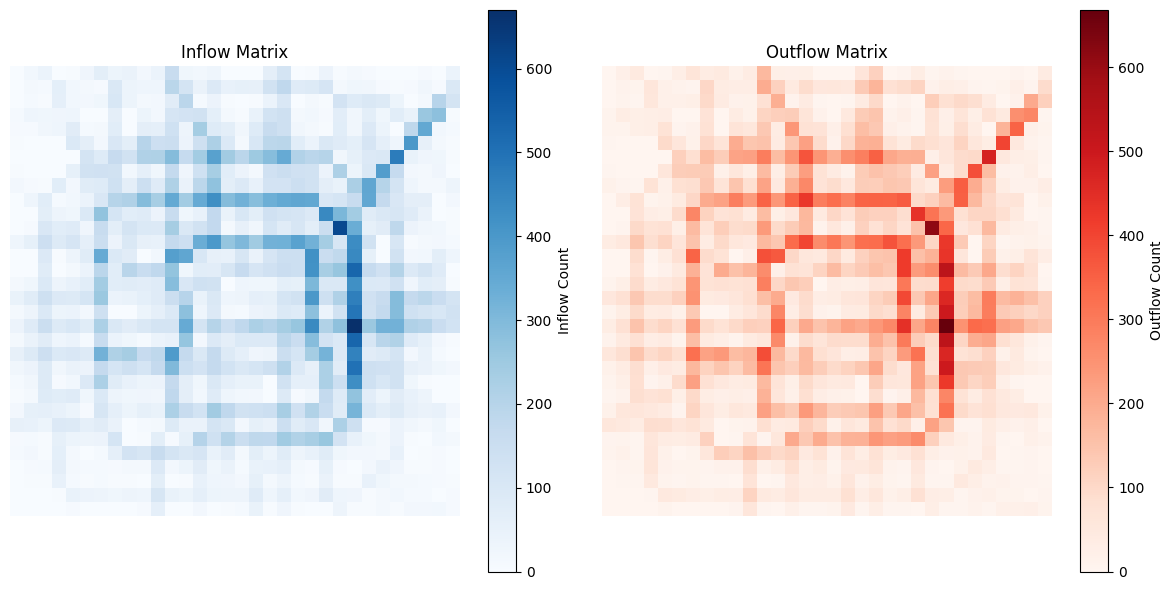

In [ ]:
import matplotlib.pyplot as plt
# Plotting the matrices as heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the inflow matrix
im1 = axes[0].imshow(inflow_matrix, cmap='Blues', interpolation='nearest')
axes[0].set_title(f"Inflow Matrix")
axes[0].axis('off')  # Turn off axis for better visualization
fig.colorbar(im1, ax=axes[0], label="Inflow Count")  # Colorbar for the inflow matrix

# Plot the outflow matrix
im2 = axes[1].imshow(outflow_matrix, cmap='Reds', interpolation='nearest')
axes[1].set_title(f"Outflow Matrix")
axes[1].axis('off')  # Turn off axis for better visualization
fig.colorbar(im2, ax=axes[1], label="Outflow Count")  # Colorbar for the outflow matrix

# Display the plots
plt.tight_layout()
plt.show()


In [ ]:
for i, item in enumerate(data_all):
    print(f"Shape of item {i}: {np.shape(item)}")


Shape of item 0: (4848, 2, 32, 32)
Shape of item 1: (4368, 2, 32, 32)
Shape of item 2: (5520, 2, 32, 32)
Shape of item 3: (6624, 2, 32, 32)


In [ ]:
import numpy as np

inflow_data_list = []

# Loop over the first 3 items in data_all
for i in range(4):  # You can adjust the range based on the number of items you want to process
    # Convert the current item in data_all to a numpy array
    data_item = np.array(data_all[i])

    # Extract the inflow data (first channel) for the current item
    inflow_data = data_item[:, 0, :, :]  # Select the first channel (inflow)

    # Append the inflow data to the list
    inflow_data_list.append(inflow_data)

In [ ]:
print(inflow_data_list)

[array([[[  0.,  20.,  41., ...,   7.,   1.,  40.],
        [  0.,  11.,   8., ...,  22.,   7.,  96.],
        [  0.,   9.,   5., ...,  14., 198., 117.],
        ...,
        [  1.,   3.,   4., ...,   8.,   6.,   3.],
        [  0.,   0.,   0., ...,   9.,   0.,   7.],
        [  1.,   0.,   0., ...,  17.,  20.,   7.]],

       [[  0.,  12.,  19., ...,   2.,   3.,  40.],
        [  0.,   7.,  10., ...,  17.,   6.,  84.],
        [  0.,   6.,   3., ...,  20., 198., 148.],
        ...,
        [  0.,   1.,   5., ...,   8.,   7.,   1.],
        [  0.,   1.,   3., ...,   8.,   0.,   4.],
        [  0.,   2.,   2., ...,  18.,  14.,   5.]],

       [[  0.,   5.,  15., ...,   1.,   2.,  33.],
        [  0.,   5.,   4., ...,  10.,   7.,  72.],
        [  0.,   2.,   6., ...,   5., 156.,  86.],
        ...,
        [  2.,   2.,   3., ...,   5.,   4.,   1.],
        [  1.,   1.,   1., ...,   7.,   1.,   0.],
        [  0.,   1.,   0., ...,   6.,   4.,   2.]],

       ...,

       [[  0.,  13.,  4

In [ ]:
inflow_data_list[0].shape

(4848, 32, 32)

# **Prepare Grid form NYC Bike Dataset**

load NYC bike data (paper)

In [ ]:
#df = pd.read_csv('/content/drive/MyDrive/Copy_merged_data_201404_09.csv')
df = pd.read_csv('/content/merged_data_201404_09.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/content/merged_data_201404_09.csv'

In [ ]:
df.shape

(5359995, 15)

In [ ]:
# Convert start station time (starttime) in each part with the correct "%Y-%m-%d %H:%M:%S" format

## Split the DataFrame due to inconsistent time formats in 'starttime' column
df1 = df.iloc[:4406108]  # Rows before the split
df2 = df.iloc[4406108:]  # Rows after the split

# Convert starttime in each part with the correct format
df1['starttime'] = pd.to_datetime(df1['starttime'], format="%Y-%m-%d %H:%M:%S")
df2['starttime'] = pd.to_datetime(df2['starttime'], format="%m/%d/%Y %H:%M:%S")

<ipython-input-10-b4a4249ae5b4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['starttime'] = pd.to_datetime(df1['starttime'], format="%Y-%m-%d %H:%M:%S")
<ipython-input-10-b4a4249ae5b4>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['starttime'] = pd.to_datetime(df2['starttime'], format="%m/%d/%Y %H:%M:%S")


In [ ]:
print(df1.head(5))
print(df2.head(5))

   tripduration           starttime             stoptime  start station id  \
0           558 2014-04-01 00:00:07  2014-04-01 00:09:25                82   
1           882 2014-04-01 00:00:20  2014-04-01 00:15:02               349   
2           587 2014-04-01 00:00:25  2014-04-01 00:10:12               293   
3           355 2014-04-01 00:00:44  2014-04-01 00:06:39               539   
4           524 2014-04-01 00:01:29  2014-04-01 00:10:13               459   

               start station name  start station latitude  \
0          St James Pl & Pearl St               40.711174   
1         Rivington St & Ridge St               40.718502   
2           Lafayette St & E 8 St               40.730287   
3  Metropolitan Ave & Bedford Ave               40.715348   
4                W 20 St & 11 Ave               40.746745   

   start station longitude  end station id         end station name  \
0               -74.000165            2008    Little West St & 1 Pl   
1               -73.98

In [ ]:
# Concatenate the two parts back together
dfc = pd.concat([df1, df2], ignore_index=True)

In [ ]:
# Define time intervals as 30 minutes
dfc['time_interval'] = dfc['starttime'].dt.floor('30T')

<ipython-input-13-7e76e96b455c>:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  dfc['time_interval'] = dfc['starttime'].dt.floor('30T')


In [ ]:
dfc.head(5)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender,time_interval
0,558,2014-04-01 00:00:07,2014-04-01 00:09:25,82,St James Pl & Pearl St,40.711174,-74.000165,2008,Little West St & 1 Pl,40.705693,-74.016777,21062,Subscriber,1982,1,2014-04-01
1,882,2014-04-01 00:00:20,2014-04-01 00:15:02,349,Rivington St & Ridge St,40.718502,-73.983299,312,Allen St & E Houston St,40.722055,-73.989111,20229,Subscriber,1988,1,2014-04-01
2,587,2014-04-01 00:00:25,2014-04-01 00:10:12,293,Lafayette St & E 8 St,40.730287,-73.990765,334,W 20 St & 7 Ave,40.742388,-73.997262,20922,Subscriber,1959,1,2014-04-01
3,355,2014-04-01 00:00:44,2014-04-01 00:06:39,539,Metropolitan Ave & Bedford Ave,40.715348,-73.960241,282,Kent Ave & S 11 St,40.708273,-73.968341,20914,Subscriber,1981,1,2014-04-01
4,524,2014-04-01 00:01:29,2014-04-01 00:10:13,459,W 20 St & 11 Ave,40.746745,-74.007756,503,E 20 St & Park Ave,40.738274,-73.987520,21051,Subscriber,1964,1,2014-04-01


In [ ]:
dfc.shape

(5359995, 16)

generate grid form dataset

In [ ]:
# Define the latitude and longitude margin of the grid map
## Find stations bounding box
min_max_station_lat_list=[dfc['start station latitude'].min(),dfc['start station latitude'].max(),dfc['end station latitude'].min(),dfc['end station latitude'].max()]
min_max_station_lon_list=[dfc['start station longitude'].min(),dfc['start station longitude'].max(),dfc['end station longitude'].min(),dfc['end station longitude'].max()]

## Define NYC bounding box as stations bounding box
min_lat, max_lat = min(min_max_station_lat_list),max(min_max_station_lat_list)
min_lon, max_lon =  min(min_max_station_lon_list),max(min_max_station_lon_list)

In [ ]:
# Define number of grid cells
grid_size_w = 24  # Number of columns in the grid
grid_size_h = 24   # Number of rows in the grid

# Compute grid step sizes
lat_step = (max_lat - min_lat) / grid_size_h  # Latitude step size
lon_step = (max_lon - min_lon) / grid_size_w  # Longitude step size


In [ ]:
# Function to map lat/lon to grid indices
def get_grid_cell(lat, lon):
    row = int((lat - min_lat) / lat_step)
    col = int((lon - min_lon) / lon_step)

    # Clamp indices to valid ranges
    row = max(0, min(grid_size_h - 1, row))  # Rows bounded by grid_size_h
    col = max(0, min(grid_size_w - 1, col))  # Columns bounded by grid_size_w

    return row, col


In [ ]:
# Initialize dictionaries to store inflow and outflow matrices for each interval
inflow_dict = {}
outflow_dict = {}

# Process data by time intervals
for interval, group in dfc.groupby('time_interval'):
#for interval, group in df.groupby('time_interval'):
    inflow_matrix = np.zeros((grid_size_h, grid_size_w))  # Rows x Columns
    outflow_matrix = np.zeros((grid_size_h, grid_size_w))  # Rows x Columns


    for _, row in group.iterrows():
        # Get grid cell for start and end stations
        start_row, start_col = get_grid_cell(row['start station latitude'], row['start station longitude'])
        end_row, end_col = get_grid_cell(row['end station latitude'], row['end station longitude'])

        # Increment inflow and outflow counts
        outflow_matrix[start_row, start_col] += 1
        inflow_matrix[end_row, end_col] += 1

    # Store matrices for the time interval
    inflow_dict[interval] = inflow_matrix
    outflow_dict[interval] = outflow_matrix

In [ ]:
import pickle

# Save inflow_dict and outflow_dict to a file
with open('/content/drive/MyDrive/flow_data.pkl', 'wb') as f:
    pickle.dump({'inflow': inflow_dict, 'outflow': outflow_dict}, f)

In [ ]:
# Check inflow outflow dict matrices with example interval 1

example_interval_1 = list(inflow_dict.keys())[23]
print("Inflow matrix for interval:", example_interval_1)
print(inflow_dict[example_interval_1])

print("Outflow matrix for interval:", example_interval_1)
print(outflow_dict[example_interval_1])

Inflow matrix for interval: 2014-04-01 11:30:00
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  1.  2.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  4.  5.  2.  0.  0.  1.  2.  0.  1.  0.  2.]
 [ 4. 18. 13.  0.  1.  0.  4.  0.  1.  0.  0.  0.  0.  2.  0.  0.]
 [ 8. 10.  4. 17. 12.  6. 20.  7.  6.  5.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. 10.  8. 13. 14. 33.  8. 11.  2.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 20. 14. 20. 18. 21.  8. 11.  2.  3.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  3.  2.  7.  5.  8.  9.  5.  9.  8.  2.  2.  0.  0.]
 [ 0.  0.  0.  0.  1.  1.  1.  0. 11.  6.  2.  2.  1.  0.  0.  0.]]
Outflow matrix for interval: 2014-04-01 11:30:00
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  1.  0.  3.  0.  0.  0.]
 [ 1.  1.  0.  0.  0.  2.  4.  4.  1.  2.  0.  0.  2.  0.  0.  0.]
 [ 5.  6. 14.  0.  5.  3.  0.  4.  0.  0.  0.  2.  1.  0.  2.  0.]
 [13. 18.  5.  4. 18.  4. 26.  5.  9.  4.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 10. 11.  8. 10. 27.  9.  9.  3.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  9. 19. 22. 21. 15.  

In [ ]:
# Check inflow outflow dict matrices with example interval 1

example_interval_1 = list(inflow_dict.keys())[510]
print("Inflow matrix for interval:", example_interval_1)
print(inflow_dict[example_interval_1])

print("Outflow matrix for interval:", example_interval_1)
print(outflow_dict[example_interval_1])

Inflow matrix for interval: 2014-04-11 15:00:00
[[ 0.  0.  0.  0.  1.  0.  1.  3.  2.  4.  1.  2.  0.  1.  0.  0.]
 [ 0.  2.  0.  0.  0.  3.  9.  2.  1.  2.  1.  2.  0.  0.  0.  0.]
 [11. 13. 25.  0.  3.  5.  2.  3.  4.  0.  0.  1.  2.  2.  0.  0.]
 [ 4. 14.  5. 13.  9.  8. 16.  6. 10.  4.  0.  0.  0.  2.  0.  0.]
 [ 0.  0. 13. 12. 31. 24. 38. 25. 20.  7.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 17. 25. 17. 20. 16.  6.  9. 14.  8.  0.  0.  0.  0.  0.]
 [ 0.  0.  5.  6.  4. 25. 59.  8. 14. 26. 14.  9.  3.  2.  0.  0.]
 [ 0.  0.  0.  7.  4.  6. 16.  4. 19.  6.  4.  4.  2.  0.  0.  0.]]
Outflow matrix for interval: 2014-04-11 15:00:00
[[ 0.  0.  0.  0.  0.  2.  3.  0.  1.  2.  3.  0.  0.  1.  0.  1.]
 [ 0.  4.  0.  0.  0.  4.  9.  4.  3.  0.  1.  0.  1.  1.  0.  3.]
 [16. 11. 28.  0.  4.  2.  2.  0.  1.  0.  0.  1.  0.  0.  1.  0.]
 [17.  8. 12. 13.  7. 14. 24.  5. 12.  5.  0.  0.  2.  2.  0.  0.]
 [ 0.  0. 16. 12. 25. 19. 23. 16. 13.  6.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 21. 24. 14. 24. 35. 1

In [ ]:
# Check inflow outflow dict matrices with example interval 2

example_interval_2 = list(inflow_dict.keys())[50]
print("Inflow matrix for interval:", example_interval_2)
print(inflow_dict[example_interval_2])

print("Outflow matrix for interval:", example_interval_2)
print(outflow_dict[example_interval_2])

Inflow matrix for interval: 2014-04-02 01:00:00
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.

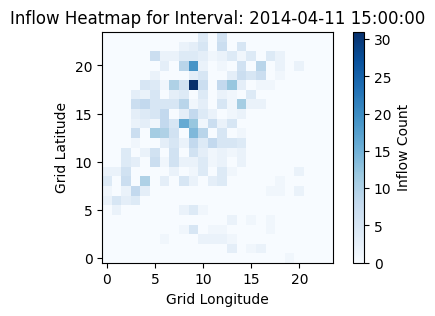

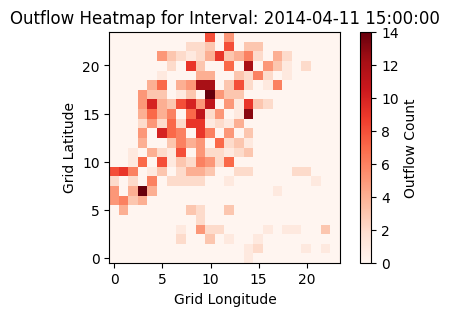

In [ ]:

# Print inflow Heatmap
plt.figure(figsize=(5, 3))
plt.imshow(inflow_dict[example_interval_1], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_interval_1}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

# Print outflow Heatmap
plt.figure(figsize=(5, 3))
plt.imshow(outflow_dict[example_interval_1], cmap='Reds', origin='lower')
plt.colorbar(label='Outflow Count')
plt.title(f'Outflow Heatmap for Interval: {example_interval_1}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

In [ ]:
# Combine inflow and outflow into a single tensor
combined_dict = {}
for interval in inflow_dict.keys():
    inflow = inflow_dict[interval]  # Shape: (24, 24)
    outflow = outflow_dict[interval]  # Shape: (24, 24)
    combined = np.stack([inflow, outflow], axis=-1)  # Shape: (24, 24, 2)
    combined_dict[interval] = combined

In [ ]:
#Sort intervals and create a list of combined matrices
sorted_intervals = sorted(combined_dict.keys())
data = np.array([combined_dict[interval] for interval in sorted_intervals])  # Shape: (T, 24, 24, 2)

In [ ]:
# 16*8
data.shape

(8784, 8, 16, 2)

In [ ]:
#24*24
data.shape

(8784, 24, 24, 2)

load nyc bike data (2020 opencity)

In [ ]:
import os

In [ ]:
data_path = os.path.join('/content/drive/MyDrive/uc_models/NYC_BIKE-3/NYC_BIKE-3.npz')
data_raw = np.load(data_path)

In [ ]:
print(f"Keys in the file: {list(data_raw.keys())}")
key_name = list(data_raw.keys())[0]  # Example: Access the first key
print(f"Inspecting data for key '{key_name}':")
print(data_raw[key_name].shape)  # Check the shape of the dataset

Keys in the file: ['data']
Inspecting data for key 'data':
(105216, 540, 2)


In [ ]:
inflow = data_raw['data'][:, :, 0]  # Assume inflow
outflow = data_raw['data'][:, :, 1]  # Assume outflow

# Print the first timestep
print("First timestep inflow:")
print(inflow[0])

print("First timestep outflow:")
print(outflow[0])

First timestep inflow:
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 3.
 2. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 9. 0. 2. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 4.
 8. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 9. 4.
 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 6. 4. 1.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 

In [ ]:
grid_size = int(np.sqrt(540))
print(f"Grid size: {grid_size}")

Grid size: 23


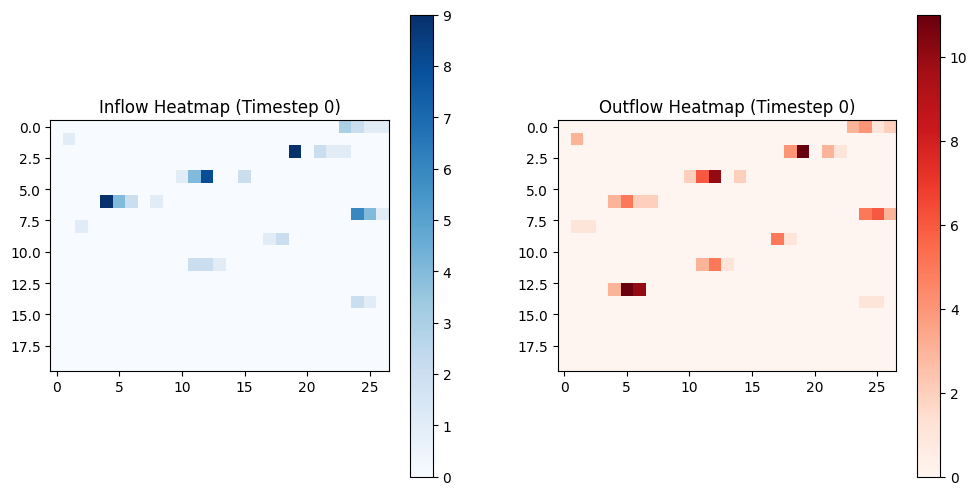

In [ ]:
import matplotlib.pyplot as plt

# Visualize inflow and outflow for a specific timestep
timestep = 0

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Inflow Heatmap (Timestep {timestep})")
plt.imshow(inflow[timestep].reshape(20, 27), cmap="Blues")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title(f"Outflow Heatmap (Timestep {timestep})")
plt.imshow(outflow[timestep].reshape(20, 27), cmap="Reds")  # Assuming a 20x27 grid
plt.colorbar()

plt.show()


In [ ]:
#only 2020 inflow? data
data = np.load(data_path)['data'][(366+365+365+365)*48:(366+365+365+365+366)*48, :, 0]

In [ ]:
print(f"Data shape: {data.shape}")

Data shape: (17568, 540)


In [ ]:
print(data[:5])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


# **Loading MOMENT**

In [ ]:
pip install git+https://github.com/moment-timeseries-foundation-model/moment.git

  Cloning https://github.com/moment-timeseries-foundation-model/moment.git to /tmp/pip-req-build-bq04tjmk
  Running command git clone --filter=blob:none --quiet https://github.com/moment-timeseries-foundation-model/moment.git /tmp/pip-req-build-bq04tjmk
  Resolved https://github.com/moment-timeseries-foundation-model/moment.git to commit fb620934ef6b67f878bc21b8640b22d117dbffa6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
from momentfm import MOMENTPipeline

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


implement model params from https://github.com/moment-timeseries-foundation-model/moment/blob/main/tutorials/forecasting.ipynb

In [ ]:
del model
del train_loader
del test_loader

In [ ]:
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 48,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

In [ ]:
model.init()
print(model)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/usr/local/lib/python3.10/dist-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


# **MODEL INPUT**

In [ ]:
#nyc bike
# Data Shape: (T, 24, 24, 2)
# Flatten the 24*24 grid into a 576 sequence
data = data.reshape(data.shape[0], data.shape[1]*data.shape[2], data.shape[3])  # Shape: (T, 576, 2)
data.shape

(8784, 576, 2)

In [ ]:
# bjtaxi
inflow_data_list[0].shape

(4848, 32, 32)

In [ ]:

#inflow_data = (inflow_data - inflow_data.mean()) / inflow_data.std()

In [ ]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined

In [ ]:
del model
del train_loader
del test_loader

In [ ]:
import torch

# Assuming inflow_data_list[0] is a NumPy array with shape (4848, 1024, 1)
data = torch.tensor(inflow_data_list[0])  # Convert to PyTorch tensor

# Remove the singleton dimension using unsqueeze to achieve (4848, 1, 1024)
data = data.squeeze(2)  # Remove the last dimension (1)
data = data.unsqueeze(1)  # Add a new singleton dimension at position 1

# Verify the shape
print(data.shape)  # Should print torch.Size([4848, 1, 1024])


torch.Size([4848, 1, 32, 32])


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define context length, forecast horizon, and batch size
context_length = 512  # Number of timesteps used as input
forecast_horizon = 48  # Number of timesteps to predict
batch_size = 4  # Number of sequences in each batch

# Split data into training (April–August) and testing (September)
train_timesteps =  4242 # Number of timesteps for April–August
train_data = inflow_data[:train_timesteps]  # Shape: (7344, 1, 576)
test_data = inflow_data[train_timesteps:]  # Shape: (1440, 1, 576)

# Prepare training data: split into timeseries and forecast
train_timeseries = []
train_forecast = []

for i in range(0, train_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for training
    train_timeseries.append(torch.tensor(train_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for training
    train_forecast.append(torch.tensor(train_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert training data to tensors
train_timeseries = torch.stack(train_timeseries)  # Shape: (n_samples, 512, 1, 576)
train_forecast = torch.stack(train_forecast)  # Shape: (n_samples, 48, 1, 576)
"""
# Flatten Training Data
train_timeseries = train_timeseries.view(train_timeseries.shape[0], train_timeseries.shape[1], -1)  # Shape: (199, 256, 1024)
train_forecast = train_forecast.view(train_forecast.shape[0], train_forecast.shape[1], -1)  # Shape: (199, 20, 1024)
"""
# Create input mask for training
train_mask = torch.ones(train_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create training TensorDataset and DataLoader
train_dataset = TensorDataset(train_timeseries, train_forecast, train_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data: split into timeseries and forecast
test_timeseries = []
test_forecast = []

for i in range(0, test_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for testing
    test_timeseries.append(torch.tensor(test_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for testing
    test_forecast.append(torch.tensor(test_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert testing data to tensors
test_timeseries = torch.stack(test_timeseries)  # Shape: (n_samples, 512, 1, 576)
test_forecast = torch.stack(test_forecast)  # Shape: (n_samples, 48, 1, 576)

"""
# Flatten Testing Data
test_timeseries = test_timeseries.view(test_timeseries.shape[0], test_timeseries.shape[1], -1)  # Shape: (106, 256, 1024)
test_forecast = test_forecast.view(test_forecast.shape[0], test_forecast.shape[1], -1)  # Shape: (106, 20, 1024)
"""
# Create input mask for testing
test_mask = torch.ones(test_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create testing TensorDataset and DataLoader
test_dataset = TensorDataset(test_timeseries, test_forecast, test_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for evaluation

# Print dataset info
print(f"Training Timeseries shape: {train_timeseries.shape}")
print(f"Training Forecast shape: {train_forecast.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Testing Timeseries shape: {test_timeseries.shape}")
print(f"Testing Forecast shape: {test_forecast.shape}")
print(f"Number of testing batches: {len(test_loader)}")


Training Timeseries shape: torch.Size([77, 512, 32, 32])
Training Forecast shape: torch.Size([77, 48, 32, 32])
Number of training batches: 20
Testing Timeseries shape: torch.Size([38, 512, 32, 32])
Testing Forecast shape: torch.Size([38, 48, 32, 32])
Number of testing batches: 10


In [ ]:
import gc
gc.collect()

26

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming inflow_data is a tensor of shape [batch_size, timesteps, 32, 32]
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

# Loop through the training data
for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
    # Move data to the device
    batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 32, 32)
    batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 480, 32, 32)
    batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

    # Flatten the spatial dimensions (32x32 -> 1024) for each time step
    batch_timeseries = batch_timeseries.view(batch_timeseries.shape[0], batch_timeseries.shape[1], -1)  # Shape: (batch_size, 512, 1024)

    # Permute to match the model's expected input (batch_size, n_channels, seq_len)
    input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 1024, 512)

    # Forward pass
    with torch.cuda.amp.autocast():
        output = model(x_enc=input_tensor, input_mask=batch_mask)

    # Reshape forecast to match model output
    batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: (batch_size, 480, 1024)
    batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 1024, 480)

    # Compute loss
    loss = criterion(output.forecast, batch_forecast)

    # Backward pass, optimizer step, etc.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print progress
    print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")


<ipython-input-22-69d842ed6ff0>:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Batch 1/20: Loss = 38.68110656738281
Batch 2/20: Loss = 46.71766662597656
Batch 3/20: Loss = 40.94802474975586


KeyboardInterrupt: 

In [ ]:
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")


Test RMSE: 31.6343 | Test MAE: 18.2478


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming inflow_data is a tensor of shape [batch_size, timesteps, 32, 32]
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

# Number of epochs
num_epochs = 1

# Loop through epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # To keep track of the loss for the epoch

    # Loop through the training data
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
        # Move data to the device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 32, 32)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 480, 32, 32)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Flatten the spatial dimensions (32x32 -> 1024) for each time step
        batch_timeseries = batch_timeseries.view(batch_timeseries.shape[0], batch_timeseries.shape[1], -1)  # Shape: (batch_size, 512, 1024)

        # Permute to match the model's expected input (batch_size, n_channels, seq_len)
        input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 1024, 512)

        # Forward pass
        with torch.cuda.amp.autocast():
            output = model(x_enc=input_tensor, input_mask=batch_mask)

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: (batch_size, 480, 1024)
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 1024, 480)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Print progress for the current batch
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Print average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} completed. Average Loss = {avg_epoch_loss:.4f}")


<ipython-input-25-d362f46ab6e9>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/1, Batch 1/466: Loss = 30.912248611450195
Epoch 1/1, Batch 2/466: Loss = 21.255380630493164
Epoch 1/1, Batch 3/466: Loss = 32.25034713745117
Epoch 1/1, Batch 4/466: Loss = 21.976688385009766
Epoch 1/1, Batch 5/466: Loss = 24.16276741027832
Epoch 1/1, Batch 6/466: Loss = 25.364723205566406
Epoch 1/1, Batch 7/466: Loss = 33.25731658935547
Epoch 1/1, Batch 8/466: Loss = 27.9517765045166
Epoch 1/1, Batch 9/466: Loss = 21.863908767700195
Epoch 1/1, Batch 10/466: Loss = 22.605831146240234
Epoch 1/1, Batch 11/466: Loss = 20.66019630432129
Epoch 1/1, Batch 12/466: Loss = 14.260026931762695
Epoch 1/1, Batch 13/466: Loss = 17.153100967407227
Epoch 1/1, Batch 14/466: Loss = 22.285385131835938
Epoch 1/1, Batch 15/466: Loss = 19.631122589111328
Epoch 1/1, Batch 16/466: Loss = 22.94292449951172
Epoch 1/1, Batch 17/466: Loss = 24.65557861328125
Epoch 1/1, Batch 18/466: Loss = 20.064193725585938
Epoch 1/1, Batch 19/466: Loss = 28.40283966064453
Epoch 1/1, Batch 20/466: Loss = 33.31684494018555

In [ ]:
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.view(batch_timeseries.size(0), batch_timeseries.size(1), -1).permute(0, 2, 1)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Flatten spatial dimensions (32x32 -> 1024)
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: [4, 2, 1024]

        # Permute to match the model's expected input format
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: [4, 1024, 2]

        # Compute loss (MAE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")

KeyboardInterrupt: 

In [ ]:
import torch

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the device
        batch_timeseries = batch_timeseries.to(device)  # Shape: (batch_size, 512, 32, 32)
        batch_forecast = batch_forecast.to(device)  # Shape: (batch_size, 20, 32, 32)

        # Flatten spatial dimensions (32x32 -> 1024)
        batch_timeseries = batch_timeseries.view(batch_timeseries.size(0), batch_timeseries.size(1), -1).permute(0, 2, 1)
        batch_forecast = batch_forecast.view(batch_forecast.size(0), batch_forecast.size(1), -1).permute(0, 2, 1)

        # Forward pass
        output = model(x_enc=batch_timeseries, input_mask=batch_mask.to(device))

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values
        all_trues.append(batch_forecast.cpu())
        all_preds.append(output.forecast.cpu())

# Combine true and predicted values for metric computation
all_trues = torch.cat(all_trues, dim=0).numpy()
all_preds = torch.cat(all_preds, dim=0).numpy()

# Compute forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")


Test RMSE: 26.2460 | Test MAE: 14.5182


/usr/local/lib/python3.10/dist-packages/momentfm/utils/forecasting_metrics.py:49: RuntimeWarning: divide by zero encountered in divide
  div = a / b


In [ ]:
del model
del train_loader
del test_loader

In [ ]:
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 48,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [ ]:
model.init()

/usr/local/lib/python3.10/dist-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
import gc
gc.collect()

16518

In [ ]:
torch.cuda.empty_cache()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define context length, forecast horizon, and batch size
context_length = 512  # Number of timesteps used as input
forecast_horizon = 48  # Number of timesteps to predict
batch_size = 4  # Number of sequences in each batch

# Split data into training (April–August) and testing (September)
train_timesteps =  4242 # Number of timesteps for April–August
train_data = inflow_data[:train_timesteps]  # Shape: (7344, 1, 576)
test_data = inflow_data[train_timesteps:]  # Shape: (1440, 1, 576)

# Prepare training data: split into timeseries and forecast
train_timeseries = []
train_forecast = []

for i in range(0, train_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for training
    train_timeseries.append(torch.tensor(train_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for training
    train_forecast.append(torch.tensor(train_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Move training data to the GPU
train_timeseries = [ts.to('cuda', non_blocking=True) for ts in train_timeseries]
train_forecast = [fc.to('cuda', non_blocking=True) for fc in train_forecast]

# Convert training data to tensors
train_timeseries = torch.stack(train_timeseries)  # Shape: (n_samples, 512, 1, 576)
train_forecast = torch.stack(train_forecast)  # Shape: (n_samples, 48, 1, 576)
"""
# Flatten Training Data
train_timeseries = train_timeseries.view(train_timeseries.shape[0], train_timeseries.shape[1], -1)  # Shape: (199, 256, 1024)
train_forecast = train_forecast.view(train_forecast.shape[0], train_forecast.shape[1], -1)  # Shape: (199, 20, 1024)
"""
# Create input mask for training
train_mask = torch.ones(train_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create training TensorDataset and DataLoader
train_dataset = TensorDataset(train_timeseries, train_forecast, train_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data: split into timeseries and forecast
test_timeseries = []
test_forecast = []

for i in range(0, test_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for testing
    test_timeseries.append(torch.tensor(test_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for testing
    test_forecast.append(torch.tensor(test_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert testing data to tensors
test_timeseries = torch.stack(test_timeseries)  # Shape: (n_samples, 512, 1, 576)
test_forecast = torch.stack(test_forecast)  # Shape: (n_samples, 48, 1, 576)

"""
# Flatten Testing Data
test_timeseries = test_timeseries.view(test_timeseries.shape[0], test_timeseries.shape[1], -1)  # Shape: (106, 256, 1024)
test_forecast = test_forecast.view(test_forecast.shape[0], test_forecast.shape[1], -1)  # Shape: (106, 20, 1024)
"""
# Create input mask for testing
test_mask = torch.ones(test_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create testing TensorDataset and DataLoader
test_dataset = TensorDataset(test_timeseries, test_forecast, test_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for evaluation

# Print dataset info
print(f"Training Timeseries shape: {train_timeseries.shape}")
print(f"Training Forecast shape: {train_forecast.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Testing Timeseries shape: {test_timeseries.shape}")
print(f"Testing Forecast shape: {test_forecast.shape}")
print(f"Number of testing batches: {len(test_loader)}")


Training Timeseries shape: torch.Size([77, 512, 32, 32])
Training Forecast shape: torch.Size([77, 48, 32, 32])
Number of training batches: 20
Testing Timeseries shape: torch.Size([38, 512, 32, 32])
Testing Forecast shape: torch.Size([38, 48, 32, 32])
Number of testing batches: 10


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming inflow_data is a tensor of shape [batch_size, timesteps, 32, 32]
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

# Number of epochs
num_epochs = 10

# Loop through epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # To keep track of the loss for the epoch

    # Loop through the training data
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
        # Move data to the device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 32, 32)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 480, 32, 32)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Flatten the spatial dimensions (32x32 -> 1024) for each time step
        batch_timeseries = batch_timeseries.view(batch_timeseries.shape[0], batch_timeseries.shape[1], -1)  # Shape: (batch_size, 512, 1024)

        # Permute to match the model's expected input (batch_size, n_channels, seq_len)
        input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 1024, 512)

        # Forward pass
        with torch.cuda.amp.autocast():
            output = model(x_enc=input_tensor, input_mask=batch_mask)

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: (batch_size, 480, 1024)
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 1024, 480)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Print progress for the current batch
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Print average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} completed. Average Loss = {avg_epoch_loss:.4f}")

<ipython-input-38-5656c61a60c1>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Epoch 1/10, Batch 1/20: Loss = 5164.25390625
Epoch 1/10, Batch 2/20: Loss = 3151.480224609375
Epoch 1/10, Batch 3/20: Loss = 3680.249755859375
Epoch 1/10, Batch 4/20: Loss = 3662.023193359375
Epoch 1/10, Batch 5/20: Loss = 3419.490234375
Epoch 1/10, Batch 6/20: Loss = 3584.791748046875
Epoch 1/10, Batch 7/20: Loss = 3420.64990234375
Epoch 1/10, Batch 8/20: Loss = 2378.9833984375
Epoch 1/10, Batch 9/20: Loss = 2360.8564453125
Epoch 1/10, Batch 10/20: Loss = 2592.054443359375
Epoch 1/10, Batch 11/20: Loss = 2072.19091796875
Epoch 1/10, Batch 12/20: Loss = 1928.61572265625
Epoch 1/10, Batch 13/20: Loss = 1749.230712890625
Epoch 1/10, Batch 14/20: Loss = 2334.34375
Epoch 1/10, Batch 15/20: Loss = 2553.37744140625
Epoch 1/10, Batch 16/20: Loss = 3762.79052734375
Epoch 1/10, Batch 17/20: Loss = 3077.63525390625
Epoch 1/10, Batch 18/20: Loss = 2948.68310546875
Epoch 1/10, Batch 19/20: Loss = 2852.759521484375
Epoch 1/10, Batch 20/20: Loss = 4617.568359375
Epoch 1/10 completed. Average Loss = 

In [ ]:
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.view(batch_timeseries.size(0), batch_timeseries.size(1), -1).permute(0, 2, 1)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Flatten spatial dimensions (32x32 -> 1024)
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: [4, 2, 1024]

        # Permute to match the model's expected input format
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: [4, 1024, 2]

        # Compute loss (MAE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")

Test RMSE: 64.0556 | Test MAE: 38.4221


In [ ]:
import torch

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the device
        batch_timeseries = batch_timeseries.to(device)  # Shape: (batch_size, 512, 32, 32)
        batch_forecast = batch_forecast.to(device)  # Shape: (batch_size, 20, 32, 32)

        # Flatten spatial dimensions (32x32 -> 1024)
        batch_timeseries = batch_timeseries.view(batch_timeseries.size(0), batch_timeseries.size(1), -1).permute(0, 2, 1)
        batch_forecast = batch_forecast.view(batch_forecast.size(0), batch_forecast.size(1), -1).permute(0, 2, 1)

        # Forward pass
        output = model(x_enc=batch_timeseries, input_mask=batch_mask.to(device))

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values
        all_trues.append(batch_forecast.cpu())
        all_preds.append(output.forecast.cpu())

# Combine true and predicted values for metric computation
all_trues = torch.cat(all_trues, dim=0).numpy()
all_preds = torch.cat(all_preds, dim=0).numpy()

# Compute forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming inflow_data is a tensor of shape [batch_size, timesteps, 32, 32]
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

# Number of epochs
num_epochs = 10

# Loop through epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # To keep track of the loss for the epoch

    # Loop through the training data
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
        # Move data to the device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 32, 32)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 480, 32, 32)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Flatten the spatial dimensions (32x32 -> 1024) for each time step
        batch_timeseries = batch_timeseries.view(batch_timeseries.shape[0], batch_timeseries.shape[1], -1)  # Shape: (batch_size, 512, 1024)

        # Permute to match the model's expected input (batch_size, n_channels, seq_len)
        input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 1024, 512)

        # Forward pass
        with torch.cuda.amp.autocast():
            output = model(x_enc=input_tensor, input_mask=batch_mask)

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: (batch_size, 480, 1024)
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 1024, 480)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Print progress for the current batch
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Print average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} completed. Average Loss = {avg_epoch_loss:.4f}")



<ipython-input-23-9c792ecdc534>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10, Batch 1/20: Loss = 30.622594833374023
Epoch 1/10, Batch 2/20: Loss = 33.98501205444336
Epoch 1/10, Batch 3/20: Loss = 34.243682861328125
Epoch 1/10, Batch 4/20: Loss = 30.241680145263672
Epoch 1/10, Batch 5/20: Loss = 25.03047752380371
Epoch 1/10, Batch 6/20: Loss = 33.77761459350586
Epoch 1/10, Batch 7/20: Loss = 34.33285140991211
Epoch 1/10, Batch 8/20: Loss = 29.487674713134766
Epoch 1/10, Batch 9/20: Loss = 31.890586853027344
Epoch 1/10, Batch 10/20: Loss = 26.965599060058594
Epoch 1/10, Batch 11/20: Loss = 30.274229049682617
Epoch 1/10, Batch 12/20: Loss = 30.392087936401367
Epoch 1/10, Batch 13/20: Loss = 28.120275497436523
Epoch 1/10, Batch 14/20: Loss = 26.420440673828125
Epoch 1/10, Batch 15/20: Loss = 27.60401725769043
Epoch 1/10, Batch 16/20: Loss = 28.227123260498047
Epoch 1/10, Batch 17/20: Loss = 25.024940490722656
Epoch 1/10, Batch 18/20: Loss = 24.26740074157715
Epoch 1/10, Batch 19/20: Loss = 24.481853485107422
Epoch 1/10, Batch 20/20: Loss = 19.44759750366

In [ ]:
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.view(batch_timeseries.size(0), batch_timeseries.size(1), -1).permute(0, 2, 1)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Flatten spatial dimensions (32x32 -> 1024)
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: [4, 2, 1024]

        # Permute to match the model's expected input format
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: [4, 1024, 2]

        # Compute loss (MAE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")

Test RMSE: 61.2394 | Test MAE: 36.3909


/usr/local/lib/python3.10/dist-packages/momentfm/utils/forecasting_metrics.py:49: RuntimeWarning: divide by zero encountered in divide
  div = a / b


In [ ]:
del model
del train_loader
del test_loader

In [ ]:
model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 2,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
del model
del train_loader
del test_loader

In [ ]:
model.init()

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define context length, forecast horizon, and batch size
context_length = 512  # Number of timesteps used as input
forecast_horizon = 2  # Number of timesteps to predict
batch_size = 4  # Number of sequences in each batch

# Split data into training (April–August) and testing (September)
train_timesteps =  4320 # Number of timesteps for April–August
train_data = inflow_data[:train_timesteps]  # Shape: (7344, 1, 576)
test_data = inflow_data[train_timesteps:]  # Shape: (1440, 1, 576)

# Prepare training data: split into timeseries and forecast
train_timeseries = []
train_forecast = []

for i in range(0, train_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for training
    train_timeseries.append(torch.tensor(train_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for training
    train_forecast.append(torch.tensor(train_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Move training data to the GPU
train_timeseries = [ts.to('cuda', non_blocking=True) for ts in train_timeseries]
train_forecast = [fc.to('cuda', non_blocking=True) for fc in train_forecast]

# Convert training data to tensors
train_timeseries = torch.stack(train_timeseries)  # Shape: (n_samples, 512, 1, 576)
train_forecast = torch.stack(train_forecast)  # Shape: (n_samples, 48, 1, 576)
"""
# Flatten Training Data
train_timeseries = train_timeseries.view(train_timeseries.shape[0], train_timeseries.shape[1], -1)  # Shape: (199, 256, 1024)
train_forecast = train_forecast.view(train_forecast.shape[0], train_forecast.shape[1], -1)  # Shape: (199, 20, 1024)
"""
# Create input mask for training
train_mask = torch.ones(train_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create training TensorDataset and DataLoader
train_dataset = TensorDataset(train_timeseries, train_forecast, train_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data: split into timeseries and forecast
test_timeseries = []
test_forecast = []

for i in range(0, test_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for testing
    test_timeseries.append(torch.tensor(test_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for testing
    test_forecast.append(torch.tensor(test_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert testing data to tensors
test_timeseries = torch.stack(test_timeseries)  # Shape: (n_samples, 512, 1, 576)
test_forecast = torch.stack(test_forecast)  # Shape: (n_samples, 48, 1, 576)

"""
# Flatten Testing Data
test_timeseries = test_timeseries.view(test_timeseries.shape[0], test_timeseries.shape[1], -1)  # Shape: (106, 256, 1024)
test_forecast = test_forecast.view(test_forecast.shape[0], test_forecast.shape[1], -1)  # Shape: (106, 20, 1024)
"""
# Create input mask for testing
test_mask = torch.ones(test_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create testing TensorDataset and DataLoader
test_dataset = TensorDataset(test_timeseries, test_forecast, test_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for evaluation

# Print dataset info
print(f"Training Timeseries shape: {train_timeseries.shape}")
print(f"Training Forecast shape: {train_forecast.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Testing Timeseries shape: {test_timeseries.shape}")
print(f"Testing Forecast shape: {test_forecast.shape}")
print(f"Number of testing batches: {len(test_loader)}")

Training Timeseries shape: torch.Size([1903, 512, 32, 32])
Training Forecast shape: torch.Size([1903, 2, 32, 32])
Number of training batches: 476
Testing Timeseries shape: torch.Size([895, 512, 32, 32])
Testing Forecast shape: torch.Size([895, 2, 32, 32])
Number of testing batches: 224


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Assuming inflow_data is a tensor of shape [batch_size, timesteps, 32, 32]
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

# Number of epochs
num_epochs = 10

# Loop through epochs
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    epoch_loss = 0  # To keep track of the loss for the epoch

    # Loop through the training data
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
        # Move data to the device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 32, 32)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 480, 32, 32)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Flatten the spatial dimensions (32x32 -> 1024) for each time step
        batch_timeseries = batch_timeseries.view(batch_timeseries.shape[0], batch_timeseries.shape[1], -1)  # Shape: (batch_size, 512, 1024)

        # Permute to match the model's expected input (batch_size, n_channels, seq_len)
        input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 1024, 512)

        # Forward pass
        with torch.cuda.amp.autocast():
            output = model(x_enc=input_tensor, input_mask=batch_mask)

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: (batch_size, 480, 1024)
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 1024, 480)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Accumulate loss for the epoch
        epoch_loss += loss.item()

        # Print progress for the current batch
        print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Print average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} completed. Average Loss = {avg_epoch_loss:.4f}")



<ipython-input-40-9c792ecdc534>:37: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10, Batch 1/476: Loss = 32.977996826171875
Epoch 1/10, Batch 2/476: Loss = 29.642955780029297
Epoch 1/10, Batch 3/476: Loss = 31.187284469604492
Epoch 1/10, Batch 4/476: Loss = 21.619325637817383
Epoch 1/10, Batch 5/476: Loss = 22.549999237060547
Epoch 1/10, Batch 6/476: Loss = 61.38825988769531
Epoch 1/10, Batch 7/476: Loss = 26.837913513183594
Epoch 1/10, Batch 8/476: Loss = 40.163291931152344
Epoch 1/10, Batch 9/476: Loss = 35.62002182006836
Epoch 1/10, Batch 10/476: Loss = 48.45526123046875
Epoch 1/10, Batch 11/476: Loss = 31.63233757019043
Epoch 1/10, Batch 12/476: Loss = 27.233301162719727
Epoch 1/10, Batch 13/476: Loss = 21.5805721282959
Epoch 1/10, Batch 14/476: Loss = 29.44159698486328
Epoch 1/10, Batch 15/476: Loss = 28.280115127563477
Epoch 1/10, Batch 16/476: Loss = 23.2123966217041
Epoch 1/10, Batch 17/476: Loss = 27.85283660888672
Epoch 1/10, Batch 18/476: Loss = 34.0262451171875
Epoch 1/10, Batch 19/476: Loss = 43.74939727783203
Epoch 1/10, Batch 20/476: Loss = 2

In [ ]:
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.view(batch_timeseries.size(0), batch_timeseries.size(1), -1).permute(0, 2, 1)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Flatten spatial dimensions (32x32 -> 1024)
        batch_forecast = batch_forecast.view(batch_forecast.shape[0], batch_forecast.shape[1], -1)  # Shape: [4, 2, 1024]

        # Permute to match the model's expected input format
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: [4, 1024, 2]

        # Compute loss (MAE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test RMSE: {metrics.rmse:.4f} | Test MAE: {metrics.mae:.4f}")

Test RMSE: 23.5866 | Test MAE: 13.0572


nyc bike

In [ ]:
# MOMENT expects the shape (batch_size, n_channels, timesteps)
# Transpose data for MOMENT's Input Format
data = data.transpose(0, 2, 1) # Shape: (T, 2, 576)
data.shape

(8784, 2, 576)

In [ ]:
data.shape

(8784, 2, 576)

try inflow data only

In [ ]:
inflow_data = data[:, 0, :]

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define context length, forecast horizon, and batch size
context_length = 512  # Number of timesteps used as input
forecast_horizon = 480  # Number of timesteps to predict
batch_size = 4  # Number of sequences in each batch

# Split data into training (April–August) and testing (September)
train_timesteps = 153 * 48  # Number of timesteps for April–August
train_data = inflow_data[:train_timesteps]  # Shape: (7344, 1, 576)
test_data = inflow_data[train_timesteps:]  # Shape: (1440, 1, 576)

# Prepare training data: split into timeseries and forecast
train_timeseries = []
train_forecast = []

for i in range(0, train_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for training
    train_timeseries.append(torch.tensor(train_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for training
    train_forecast.append(torch.tensor(train_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert training data to tensors
train_timeseries = torch.stack(train_timeseries)  # Shape: (n_samples, 512, 1, 576)
train_forecast = torch.stack(train_forecast)  # Shape: (n_samples, 48, 1, 576)

# Create input mask for training
train_mask = torch.ones(train_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create training TensorDataset and DataLoader
train_dataset = TensorDataset(train_timeseries, train_forecast, train_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data: split into timeseries and forecast
test_timeseries = []
test_forecast = []

for i in range(0, test_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for testing
    test_timeseries.append(torch.tensor(test_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for testing
    test_forecast.append(torch.tensor(test_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert testing data to tensors
test_timeseries = torch.stack(test_timeseries)  # Shape: (n_samples, 512, 1, 576)
test_forecast = torch.stack(test_forecast)  # Shape: (n_samples, 48, 1, 576)

# Create input mask for testing
test_mask = torch.ones(test_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create testing TensorDataset and DataLoader
test_dataset = TensorDataset(test_timeseries, test_forecast, test_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for evaluation

# Print dataset info
print(f"Training Timeseries shape: {train_timeseries.shape}")
print(f"Training Forecast shape: {train_forecast.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Testing Timeseries shape: {test_timeseries.shape}")
print(f"Testing Forecast shape: {test_forecast.shape}")
print(f"Number of testing batches: {len(test_loader)}")


Training Timeseries shape: torch.Size([14, 512, 576])
Training Forecast shape: torch.Size([14, 480, 576])
Number of training batches: 4
Testing Timeseries shape: torch.Size([1, 512, 576])
Testing Forecast shape: torch.Size([1, 480, 576])
Number of testing batches: 1


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
    # Move data to the device
    batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 576)
    batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 576)
    batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

    # Reshape timeseries for the model
    input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

    # Forward pass
    with torch.cuda.amp.autocast():
        output = model(x_enc=input_tensor, input_mask=batch_mask)

    # Reshape forecast to match model output
    batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 576, 48)
    print(batch_forecast.shape)

    # Compute loss
    loss = criterion(output.forecast, batch_forecast)

    # Backward pass, optimizer step, etc.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print progress
    print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")


<ipython-input-62-03d42a16072e>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


torch.Size([4, 128, 480])
Batch 1/4: Loss = 59.21245574951172
torch.Size([4, 128, 480])
Batch 2/4: Loss = 33.92690658569336
torch.Size([4, 128, 480])
Batch 3/4: Loss = 35.51401901245117
torch.Size([2, 128, 480])
Batch 4/4: Loss = 29.19694709777832


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

max_epoch = 10
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

for epoch in range(max_epoch):
    model.train()
    epoch_losses = []

    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
        batch_timeseries = batch_timeseries.float().to(device)
        batch_forecast = batch_forecast.float().to(device)
        batch_mask = batch_mask.to(device)

        # Reshape timeseries for the model
        input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        with torch.cuda.amp.autocast():
            output = model(x_enc=input_tensor, input_mask=batch_mask)

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 576, 48)
        print(batch_forecast.shape)

        # Compute loss (with penalty for negative predictions)
        loss = criterion(output.forecast, batch_forecast)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Zero the gradients after each update

        epoch_losses.append(loss.item())
        print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Compute average loss for this epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch + 1}/{max_epoch}: Average Loss = {avg_epoch_loss:.4f}")

<ipython-input-68-ca50d85c22e2>:24: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


torch.Size([4, 576, 480])
Batch 1/4: Loss = 5.234753131866455
torch.Size([4, 576, 480])
Batch 2/4: Loss = 4.208002090454102
torch.Size([4, 576, 480])
Batch 3/4: Loss = 3.6064388751983643
torch.Size([2, 576, 480])
Batch 4/4: Loss = 3.470825433731079
Epoch 1/10: Average Loss = 4.1300
torch.Size([4, 576, 480])
Batch 1/4: Loss = 3.83832049369812
torch.Size([4, 576, 480])
Batch 2/4: Loss = 3.811952829360962
torch.Size([4, 576, 480])
Batch 3/4: Loss = 3.237581968307495
torch.Size([2, 576, 480])
Batch 4/4: Loss = 2.979616403579712
Epoch 2/10: Average Loss = 3.4669
torch.Size([4, 576, 480])
Batch 1/4: Loss = 3.1918351650238037
torch.Size([4, 576, 480])
Batch 2/4: Loss = 2.9876673221588135
torch.Size([4, 576, 480])
Batch 3/4: Loss = 3.099398136138916
torch.Size([2, 576, 480])
Batch 4/4: Loss = 3.127138376235962
Epoch 3/10: Average Loss = 3.1015
torch.Size([4, 576, 480])
Batch 1/4: Loss = 2.9840190410614014
torch.Size([4, 576, 480])
Batch 2/4: Loss = 2.9277498722076416
torch.Size([4, 576, 480])


In [ ]:
from momentfm.utils.forecasting_metrics import get_forecasting_metrics


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss (MSE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss (MSE)
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(average_test_loss)
print(f"Test RMSE: {rmse:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")



Test Loss (MSE): 2.6541
Test RMSE: 1.6291
Test MSE: 2.6541 | Test MAE: 0.6341


/usr/local/lib/python3.10/dist-packages/momentfm/utils/forecasting_metrics.py:49: RuntimeWarning: divide by zero encountered in divide
  div = a / b


In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss (MSE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss (MSE)
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(average_test_loss)
print(f"Test RMSE: {rmse:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")



Test Loss (MSE): 28.9631
Test RMSE: 5.3817
Test MSE: 18.4571 | Test MAE: 2.0013


In [ ]:
print(all_preds.shape)

(1, 128, 480)


In [ ]:
#24*24
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss (MSE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss (MSE)
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(average_test_loss)
print(f"Test RMSE: {rmse:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")



Test Loss (MSE): 31.9264
Test RMSE: 5.6503
Test MSE: 31.9264 | Test MAE: 2.8312


Define a Custom Loss Function with Penalty for Negative Values

In [ ]:
import torch
import torch.nn as nn

class CustomMSELossWithPenalty(nn.Module):
    def __init__(self, penalty_factor=0.00001):
        """
        Custom MSE loss function with a penalty for negative predictions.
        :param penalty_factor: Factor by which negative predictions are penalized
        """
        super(CustomMSELossWithPenalty, self).__init__()
        self.mse_loss = nn.MSELoss()
        self.penalty_factor = penalty_factor  # Penalty factor for negative predictions

    def forward(self, predicted, target):
        # Compute standard MSE loss
        mse_loss = self.mse_loss(predicted, target)

        # Create a mask for negative predictions
        negative_predictions = predicted < 0  # Boolean mask for negative values

        # Count the number of negative predictions
        negative_count = negative_predictions.sum().float()

        # Apply a penalty if there are negative predictions
        penalty = negative_count * self.penalty_factor

        # Combine MSE loss with penalty
        total_loss = mse_loss + penalty

        return total_loss


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

max_epoch = 10

penalty_factor = 0.00001  # Adjust this based on how much penalty you want for negative predictions
criterion = CustomMSELossWithPenalty(penalty_factor=penalty_factor)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(max_epoch):
    model.train()
    epoch_losses = []

    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
        batch_timeseries = batch_timeseries.float().to(device)
        batch_forecast = batch_forecast.float().to(device)
        batch_mask = batch_mask.to(device)

        # Reshape timeseries for the model
        input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        with torch.cuda.amp.autocast():
            output = model(x_enc=input_tensor, input_mask=batch_mask)

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 576, 48)
        print(batch_forecast.shape)

        # Compute loss (with penalty for negative predictions)
        loss = criterion(output.forecast, batch_forecast)

        # Backward pass
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()  # Zero the gradients after each update

        epoch_losses.append(loss.item())
        print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Compute average loss for this epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch + 1}/{max_epoch}: Average Loss = {avg_epoch_loss:.4f}")


<ipython-input-44-80bb2302cc4b>:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


torch.Size([4, 576, 480])
Batch 1/4: Loss = 7.535678386688232
torch.Size([4, 576, 480])
Batch 2/4: Loss = 6.5071587562561035
torch.Size([4, 576, 480])
Batch 3/4: Loss = 6.8210954666137695
torch.Size([2, 576, 480])
Batch 4/4: Loss = 5.067098617553711
Epoch 1/10: Average Loss = 6.4828
torch.Size([4, 576, 480])
Batch 1/4: Loss = 6.1855244636535645
torch.Size([4, 576, 480])
Batch 2/4: Loss = 6.730038166046143
torch.Size([4, 576, 480])
Batch 3/4: Loss = 7.03218936920166
torch.Size([2, 576, 480])
Batch 4/4: Loss = 5.0641961097717285
Epoch 2/10: Average Loss = 6.2530
torch.Size([4, 576, 480])
Batch 1/4: Loss = 6.494105339050293
torch.Size([4, 576, 480])
Batch 2/4: Loss = 5.959134101867676
torch.Size([4, 576, 480])
Batch 3/4: Loss = 5.908904552459717
torch.Size([2, 576, 480])
Batch 4/4: Loss = 4.359699726104736
Epoch 3/10: Average Loss = 5.6805
torch.Size([4, 576, 480])
Batch 1/4: Loss = 5.588509559631348
torch.Size([4, 576, 480])
Batch 2/4: Loss = 5.771084308624268
torch.Size([4, 576, 480])
B

In [ ]:
#24*24
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss (MSE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss (MSE)
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(average_test_loss)
print(f"Test RMSE: {rmse:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")



Test Loss (MSE): 3.3362
Test RMSE: 1.8265
Test MSE: 2.5654 | Test MAE: 0.6232


In [ ]:
#24*24
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss (MSE)
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss (MSE)
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Calculate RMSE
rmse = np.sqrt(average_test_loss)
print(f"Test RMSE: {rmse:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")



Test Loss (MSE): 28.9631
Test RMSE: 5.3817
Test MSE: 18.4571 | Test MAE: 2.0013


In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
import gc
torch.cuda.empty_cache()
gc.collect()

7073

In [ ]:
print(memory_summary(device=None, abbreviated=True))

In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Learning rate = 0.0001

for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
    # Move data to the device
    batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 576)
    batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 576)
    batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

    # Reshape timeseries for the model
    input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

    # Forward pass
    with torch.cuda.amp.autocast():
        output = model(x_enc=input_tensor, input_mask=batch_mask)

    # Reshape forecast to match model output
    batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

    # Compute loss
    loss = criterion(output.forecast, batch_forecast)

    # Backward pass, optimizer step, etc.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print progress
    print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")


<ipython-input-36-6e7f9317b2ab>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


AttributeError: 'NoneType' object has no attribute 'size'

In [ ]:
from pprint import pprint

In [ ]:
pprint(output)

TimeseriesOutputs(forecast=tensor([[[3.7793e-06, 4.9365e-06, 6.8652e-06,  ..., 2.6636e-06,
          3.1470e-06, 2.9004e-06],
         [4.2163e-06, 5.7520e-06, 7.4316e-06,  ..., 3.3545e-06,
          3.0908e-06, 3.2471e-06],
         [4.6631e-06, 6.5283e-06, 8.7549e-06,  ..., 2.2253e-06,
          3.1250e-06, 2.6343e-06],
         ...,
         [4.8413e-06, 5.8301e-06, 0.0000e+00,  ..., 2.8076e-06,
          3.1274e-06, 0.0000e+00],
         [4.5605e-06, 5.2637e-06, 7.3389e-06,  ..., 2.1521e-06,
          2.2546e-06, 2.5366e-06],
         [4.5215e-06, 5.2637e-06, 7.0312e-06,  ..., 2.5537e-06,
          2.6196e-06, 3.6914e-06]],

        [[3.9014e-06, 4.4263e-06, 6.9043e-06,  ..., 1.8347e-06,
          2.5195e-06, 2.2937e-06],
         [4.4873e-06, 4.7803e-06, 6.5234e-06,  ..., 2.1924e-06,
          0.0000e+00, 2.5391e-06],
         [0.0000e+00, 5.5469e-06, 7.1924e-06,  ..., 0.0000e+00,
          2.6953e-06, 0.0000e+00],
         ...,
         [5.1562e-06, 5.4102e-06, 6.9141e-06,  ..., 

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")


Test Loss (MSE): 2.6659
Test MSE: 2.6748 | Test MAE: 0.6299


/usr/local/lib/python3.10/dist-packages/momentfm/utils/forecasting_metrics.py:49: RuntimeWarning: divide by zero encountered in divide
  div = a / b


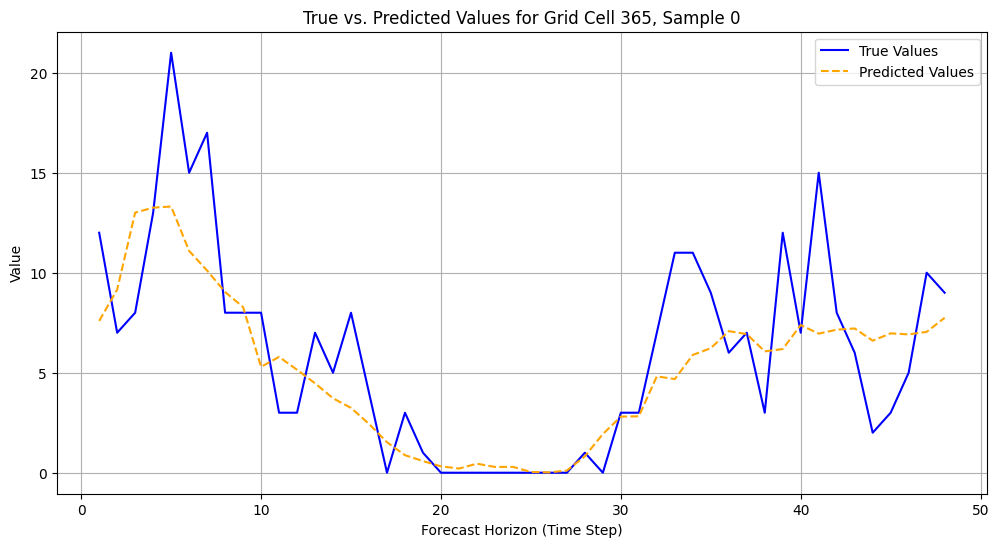

In [ ]:
import matplotlib.pyplot as plt

# Select a specific grid cell to visualize
grid_cell = 365  # Choose a grid cell index (0 to 575 for 576 grids)

# Extract true and predicted values for all 48 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 48)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 48)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 48 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()


ValueError: x and y must have same first dimension, but have shapes (48,) and (480,)

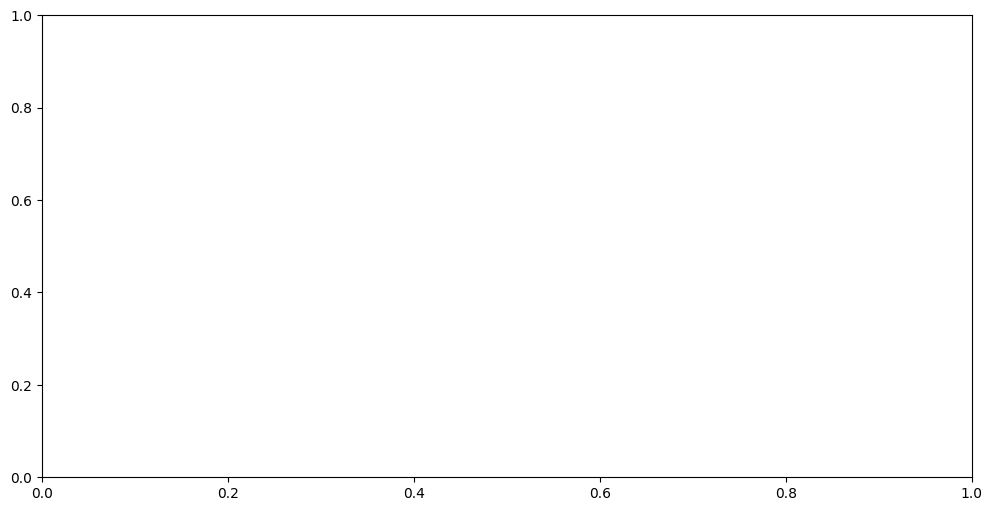

In [ ]:
import matplotlib.pyplot as plt

# Select a specific grid cell to visualize
grid_cell = 365  # Choose a grid cell index (0 to 575 for 576 grids)

# Extract true and predicted values for all 48 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 48)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 48)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 48 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def get_realtime_from_timestep(inflow_dict, forcast_timestep):
    real_timestep=forcast_timestep+7856
    time_interval = list(inflow_dict.keys())[real_timestep]

    return time_interval.strftime('%Y-%m-%d %H:%M:%S')

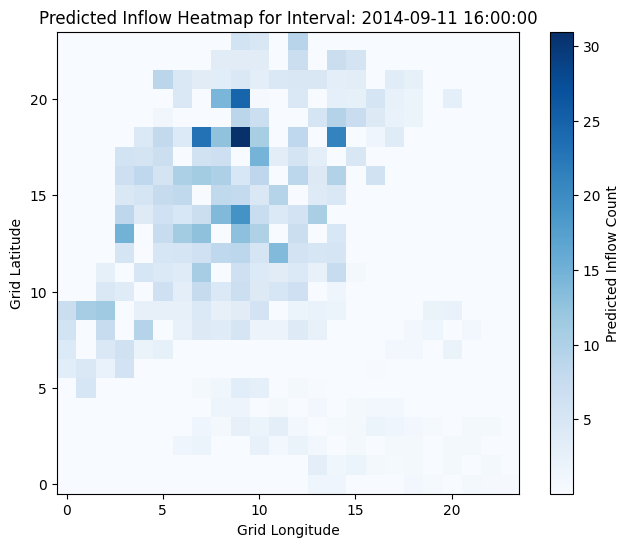

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 0  # Choose the timestep (0 to 47 for 48 timesteps) # 7856th timestep accross whole data

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()


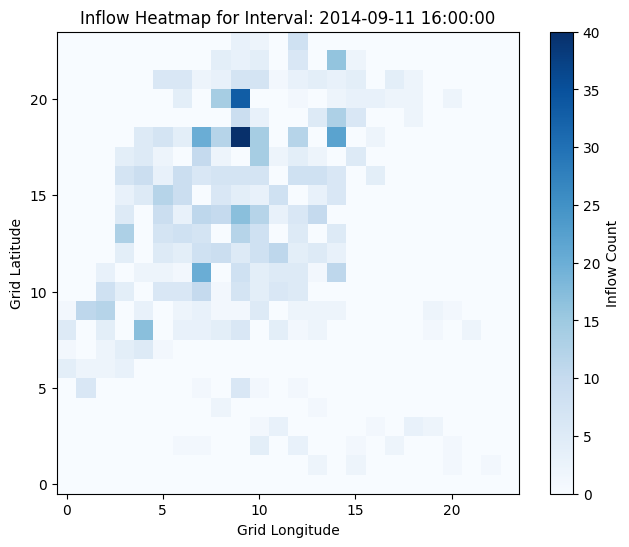

In [ ]:
example_test_interval = list(inflow_dict.keys())[7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

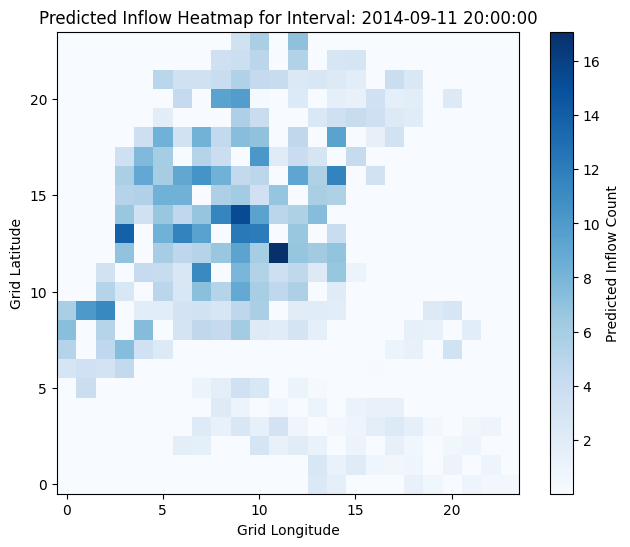

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 8  # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

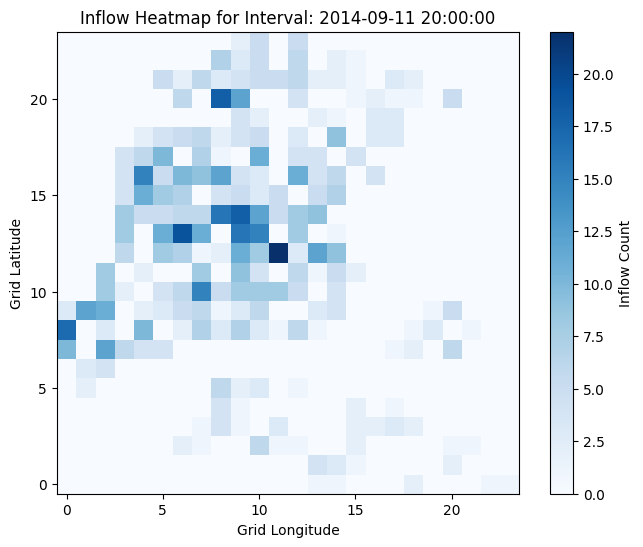

In [ ]:
example_test_interval_2 = list(inflow_dict.keys())[7864]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_2], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_2}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

In [ ]:
torch.save(model, '/content/drive/MyDrive/uc_models/MOMENT_inflow_model.pth')

try longer forcast

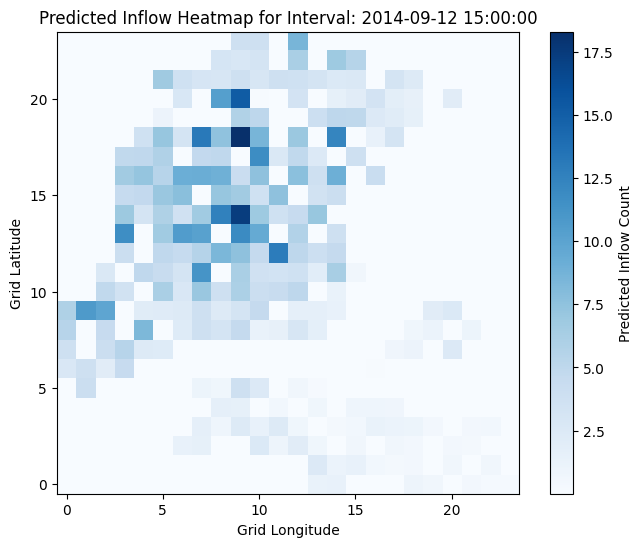

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 46   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

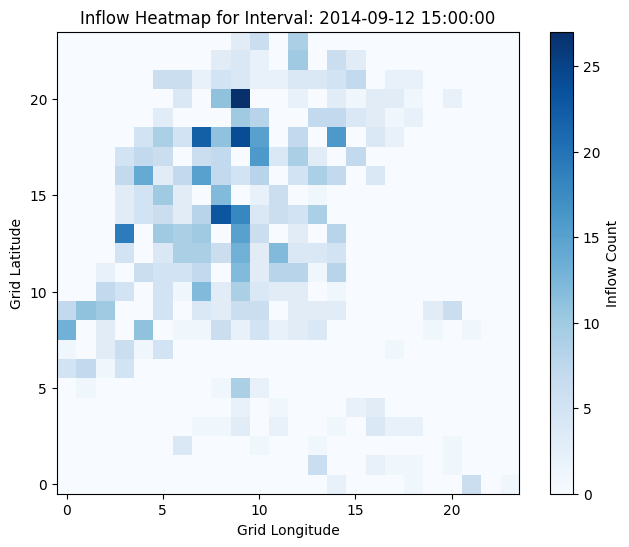

In [ ]:
example_test_interval_3 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_3], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_3}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

Tried long horizon prediction model

In [ ]:
model_long = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 480, # 10 days
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

In [ ]:
model_long.init()
print(model_long)

/usr/local/lib/python3.10/dist-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

In [ ]:
# Define context length, forecast horizon, and batch size
context_length = 512  # Number of timesteps used as input
forecast_horizon = 480  # Number of timesteps to predict
batch_size = 4  # Number of sequences in each batch

# Split data into training (April–August) and testing (September)
train_timesteps = 153 * 48  # Number of timesteps for April–August
train_data = inflow_data[:train_timesteps]  # Shape: (7344, 1, 576)
test_data = inflow_data[train_timesteps:]  # Shape: (1440, 1, 576)

# Prepare training data: split into timeseries and forecast
train_timeseries = []
train_forecast = []

for i in range(0, train_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for training
    train_timeseries.append(torch.tensor(train_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for training
    train_forecast.append(torch.tensor(train_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert training data to tensors
train_timeseries = torch.stack(train_timeseries)  # Shape: (n_samples, 512, 1, 576)
train_forecast = torch.stack(train_forecast)  # Shape: (n_samples, 48, 1, 576)

# Create input mask for training
train_mask = torch.ones(train_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create training TensorDataset and DataLoader
train_dataset = TensorDataset(train_timeseries, train_forecast, train_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data: split into timeseries and forecast
test_timeseries = []
test_forecast = []

for i in range(0, test_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for testing
    test_timeseries.append(torch.tensor(test_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for testing
    test_forecast.append(torch.tensor(test_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert testing data to tensors
test_timeseries = torch.stack(test_timeseries)  # Shape: (n_samples, 512, 1, 576)
test_forecast = torch.stack(test_forecast)  # Shape: (n_samples, 48, 1, 576)

# Create input mask for testing
test_mask = torch.ones(test_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create testing TensorDataset and DataLoader
test_dataset = TensorDataset(test_timeseries, test_forecast, test_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for evaluation

# Print dataset info
print(f"Training Timeseries shape: {train_timeseries.shape}")
print(f"Training Forecast shape: {train_forecast.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Testing Timeseries shape: {test_timeseries.shape}")
print(f"Testing Forecast shape: {test_forecast.shape}")
print(f"Number of testing batches: {len(test_loader)}")

Training Timeseries shape: torch.Size([14, 512, 576])
Training Forecast shape: torch.Size([14, 480, 576])
Number of training batches: 4
Testing Timeseries shape: torch.Size([1, 512, 576])
Testing Forecast shape: torch.Size([1, 480, 576])
Number of testing batches: 1


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model_long = model_long.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model_long.parameters(), lr=1e-4)  # Learning rate = 0.0001

for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
    # Move data to the device
    batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 576)
    batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 576)
    batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

    # Reshape timeseries for the model
    input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

    # Forward pass
    with torch.cuda.amp.autocast():
        output = model_long(x_enc=input_tensor, input_mask=batch_mask)

    # Reshape forecast to match model output
    batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

    # Compute loss
    loss = criterion(output.forecast, batch_forecast)

    # Backward pass, optimizer step, etc.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print progress
    print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")


<ipython-input-127-bdd77e7064eb>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Batch 1/4: Loss = 5.695328235626221
Batch 2/4: Loss = 4.03303337097168
Batch 3/4: Loss = 3.449981689453125
Batch 4/4: Loss = 3.9680473804473877


In [ ]:
pprint(output)

TimeseriesOutputs(forecast=tensor([[[5.1904e-06, 4.6484e-06, 3.2739e-06,  ..., 2.7319e-06,
          3.4424e-06, 4.4678e-06],
         [3.9136e-06, 3.9258e-06, 3.9331e-06,  ..., 2.1240e-06,
          2.1155e-06, 4.1235e-06],
         [5.3906e-06, 0.0000e+00, 0.0000e+00,  ..., 2.6489e-06,
          4.2554e-06, 4.4141e-06],
         ...,
         [5.0732e-06, 2.9004e-06, 0.0000e+00,  ..., 3.0957e-06,
          3.1812e-06, 4.7900e-06],
         [5.2100e-06, 3.6133e-06, 2.4744e-06,  ..., 3.2471e-06,
          2.9199e-06, 3.9722e-06],
         [4.3311e-06, 3.8721e-06, 2.4170e-06,  ..., 3.0518e-06,
          2.2070e-06, 3.8672e-06]],

        [[4.9976e-06, 4.4775e-06, 3.3887e-06,  ..., 0.0000e+00,
          2.4011e-06, 4.1162e-06],
         [4.1064e-06, 3.9990e-06, 3.4644e-06,  ..., 3.2080e-06,
          2.5928e-06, 4.1211e-06],
         [0.0000e+00, 3.5645e-06, 3.5937e-06,  ..., 2.9248e-06,
          3.4082e-06, 4.7095e-06],
         ...,
         [4.6533e-06, 3.1787e-06, 3.6108e-06,  ..., 

In [ ]:
# Set the model to evaluation mode
model_long.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 576)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 576)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

        # Forward pass
        output = model_long(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 576, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 576, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")

Test Loss (MSE): 3.6975
Test MSE: 3.6975 | Test MAE: 0.7819


/usr/local/lib/python3.10/dist-packages/momentfm/utils/forecasting_metrics.py:49: RuntimeWarning: divide by zero encountered in divide
  div = a / b


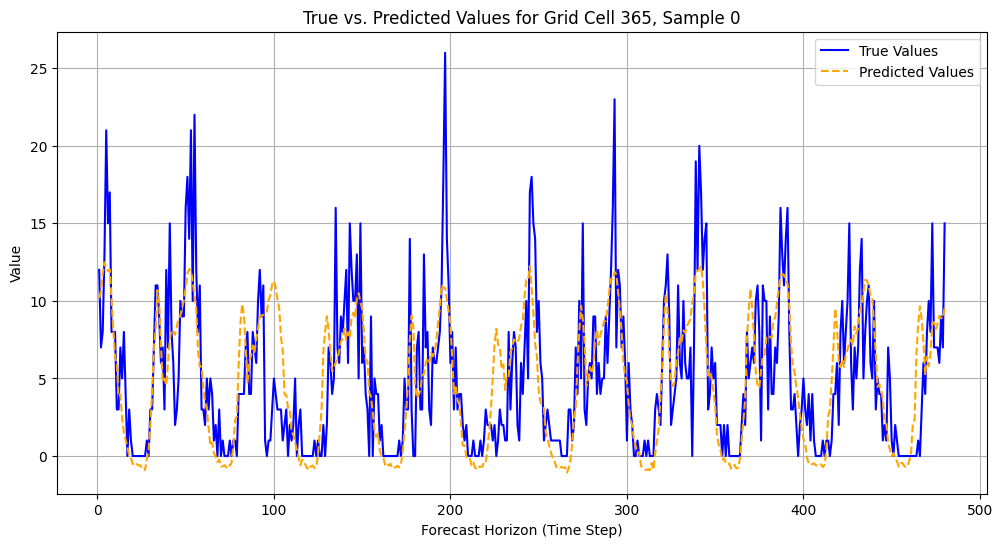

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 365  # Choose a grid cell index (0 to 575 for 576 grids)

# Extract true and predicted values for all 480 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 480)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 480)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (480,)
predicted_sample = predicted_values[sample_index]  # Shape: (480,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 481), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 481), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

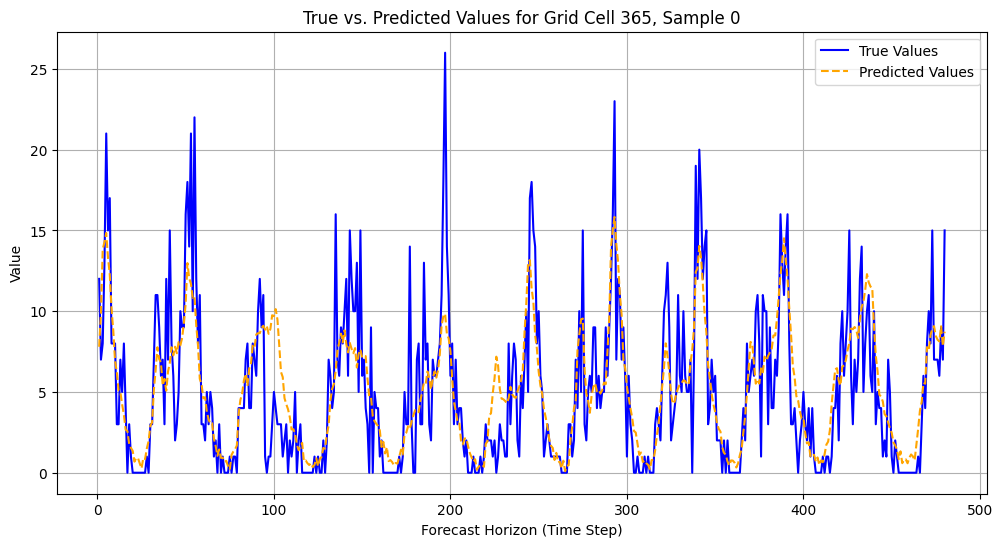

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 365  # Choose a grid cell index (0 to 575 for 576 grids)

# Extract true and predicted values for all 480 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 480)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 480)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (480,)
predicted_sample = predicted_values[sample_index]  # Shape: (480,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 481), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 481), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

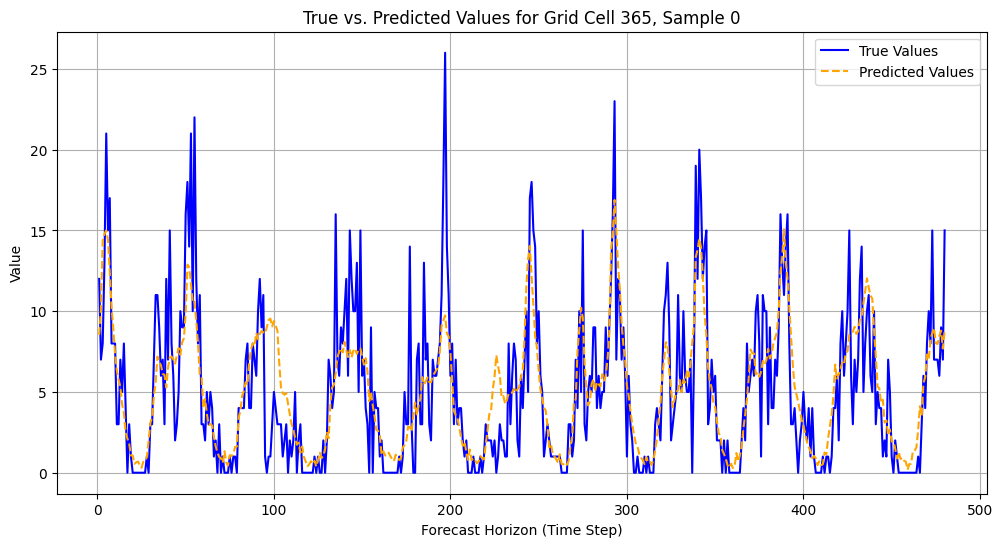

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 365  # Choose a grid cell index (0 to 575 for 576 grids)

# Extract true and predicted values for all 480 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 480)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 480)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (480,)
predicted_sample = predicted_values[sample_index]  # Shape: (480,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 481), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 481), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

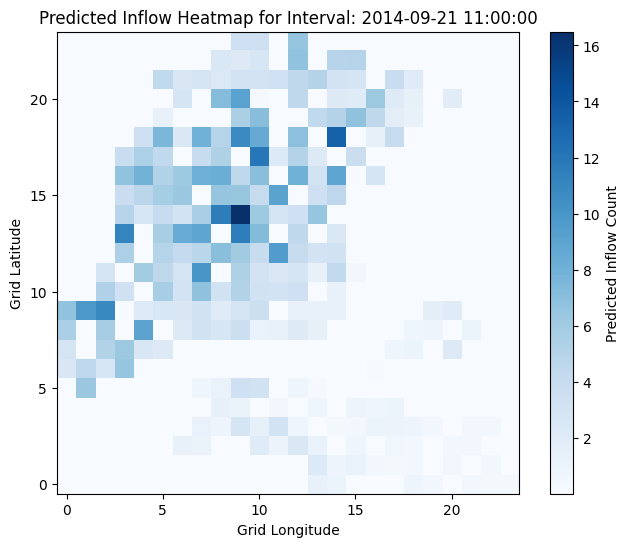

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 470   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

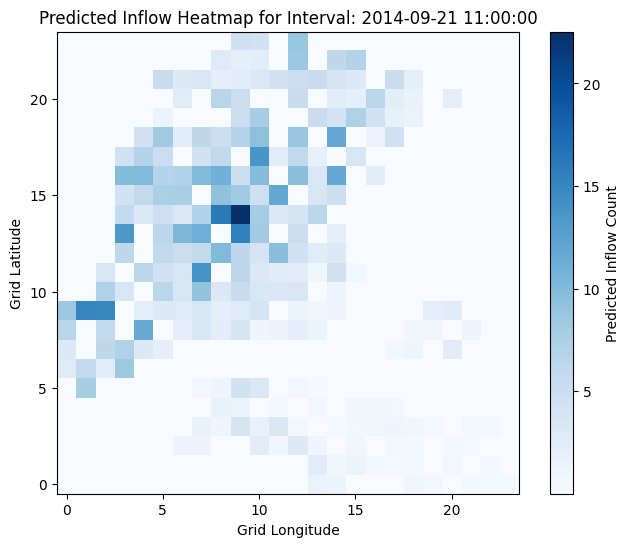

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 470   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

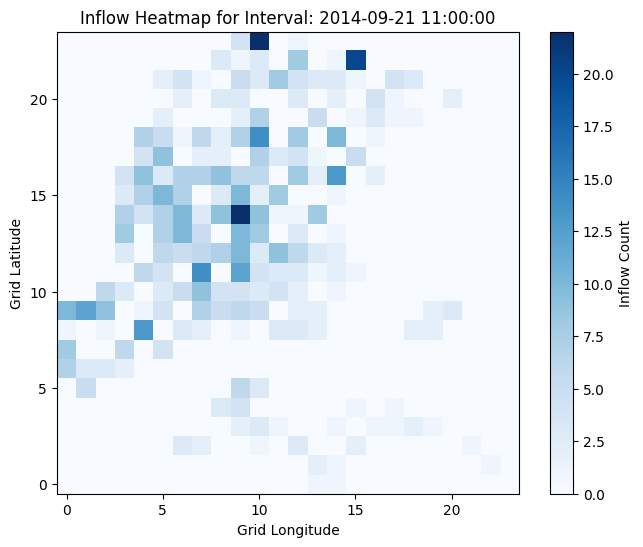

In [ ]:
example_test_interval_4 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_4], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_4}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

In [ ]:
import random
x = [random.randrange(0, 480) for p in range(0, 10)]
print(x)

[149, 96, 219, 467, 91, 368, 222, 72, 335, 186]


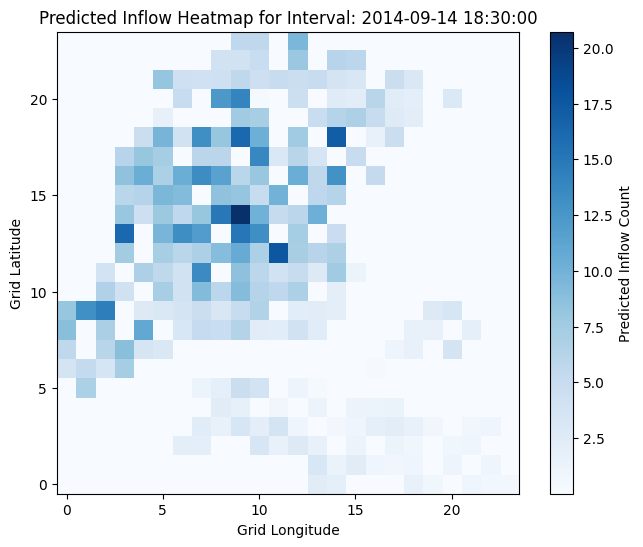

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 149   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

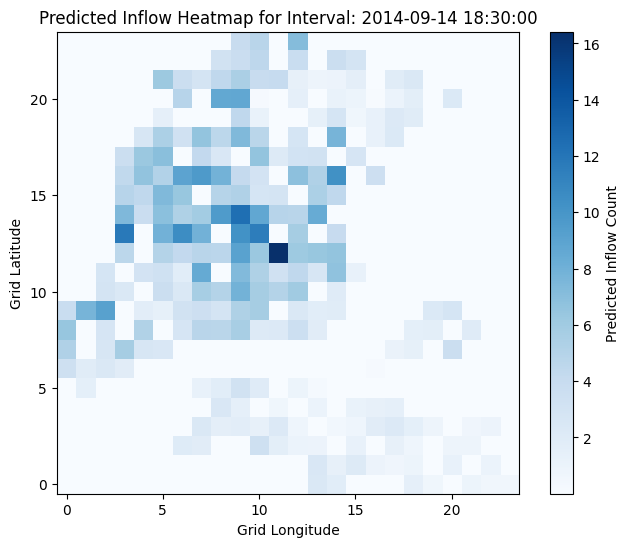

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 149   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

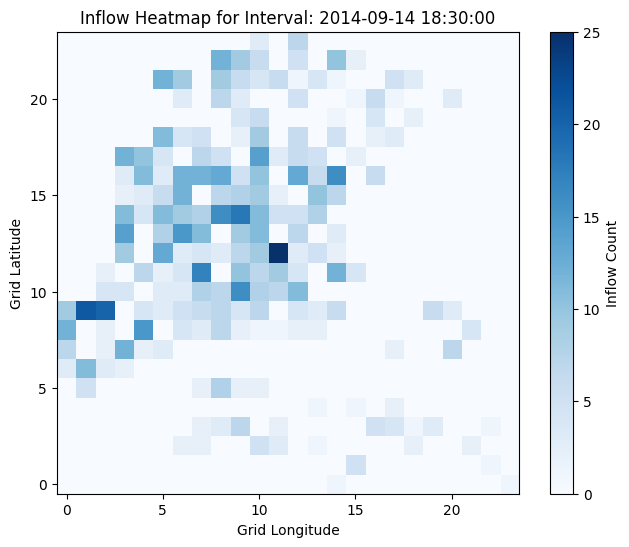

In [ ]:
example_test_interval_5 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_5], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_5}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

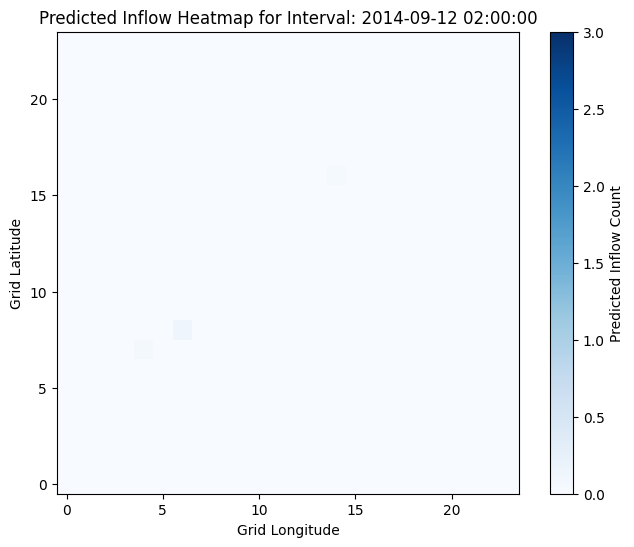

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 20   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=3,origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

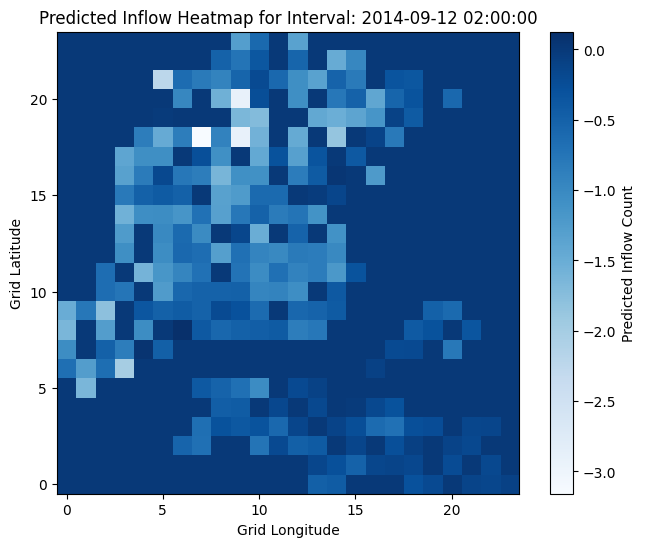

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 20   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues",origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

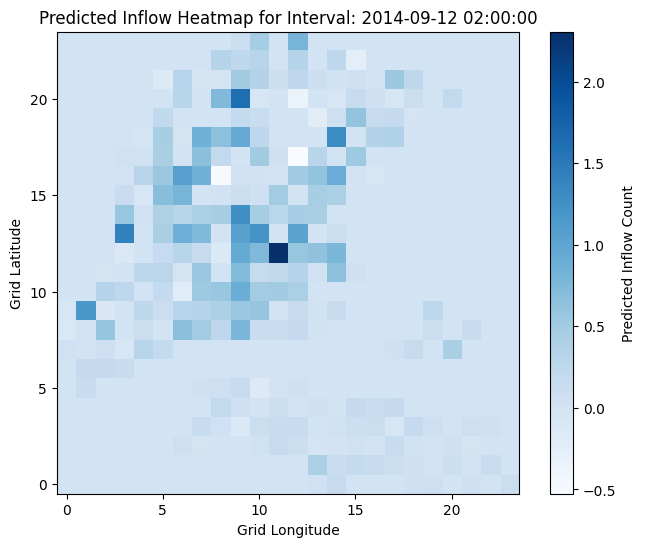

In [ ]:
import matplotlib.pyplot as plt
# Select a specific timestep (forecast horizon)
timestep = 20   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues",origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

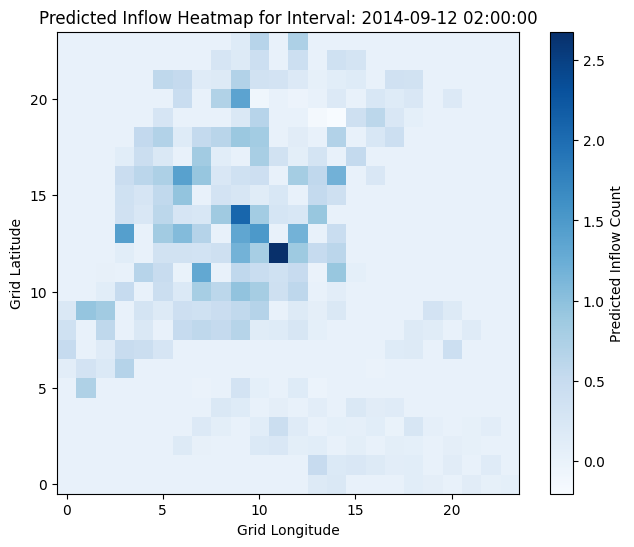

In [ ]:
import matplotlib.pyplot as plt
# Select a specific timestep (forecast horizon)
timestep = 20   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues",origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

In [ ]:
print(all_preds.shape)

(1, 128, 480)


In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 20   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)
print(predicted_inflow.shape)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues",origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

(1, 128)


ValueError: cannot reshape array of size 128 into shape (24,24)

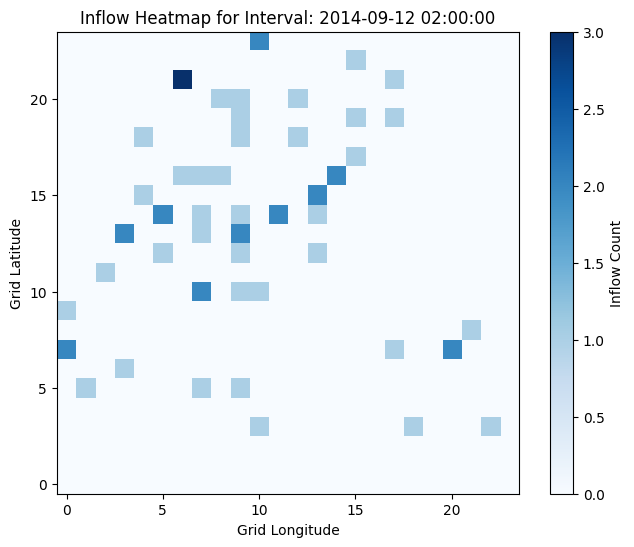

In [ ]:
example_test_interval_6 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_6], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_6}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

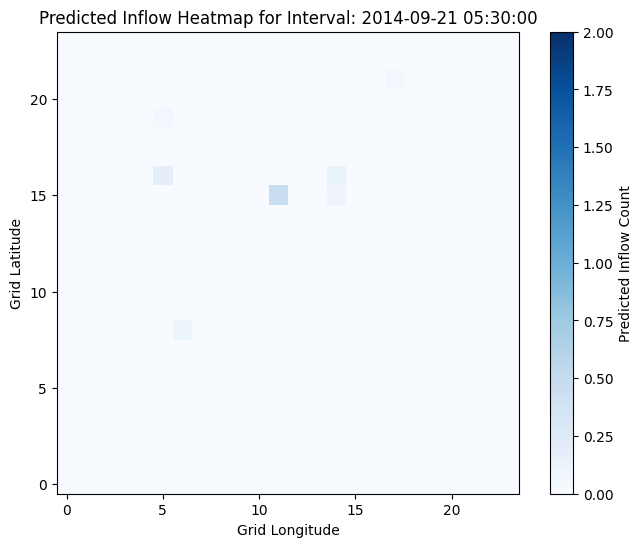

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 459   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=2, origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

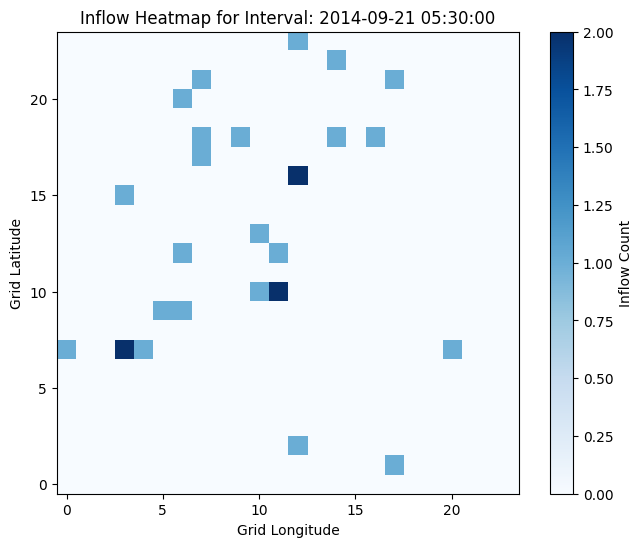

In [ ]:
example_test_interval_7 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_7], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_7}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

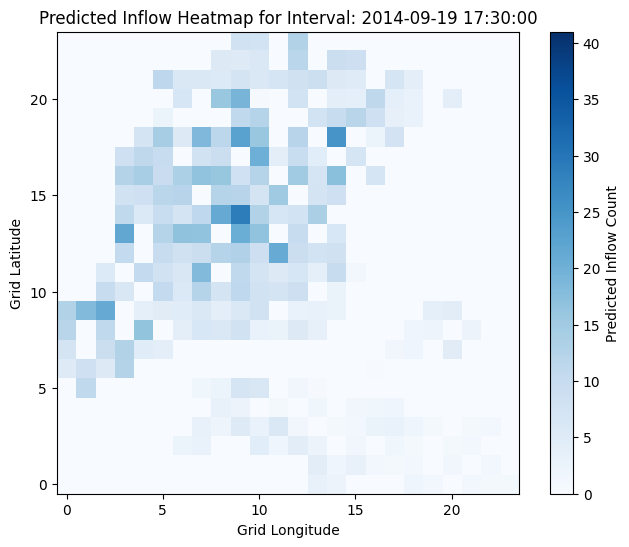

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 387   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=41, origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

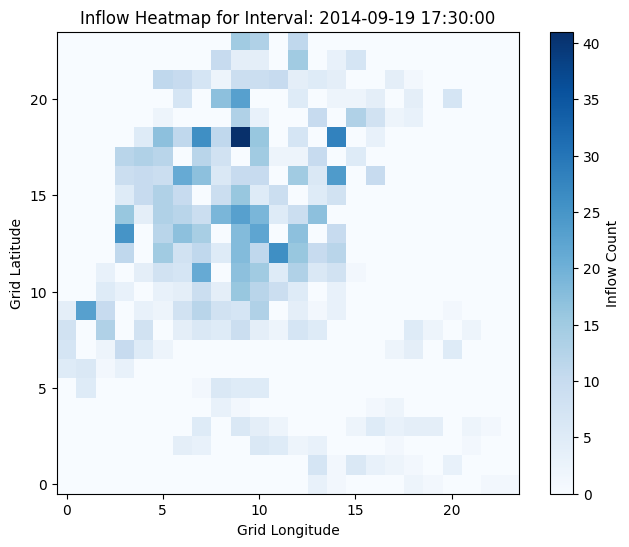

In [ ]:
example_test_interval_8 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_8], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_8}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

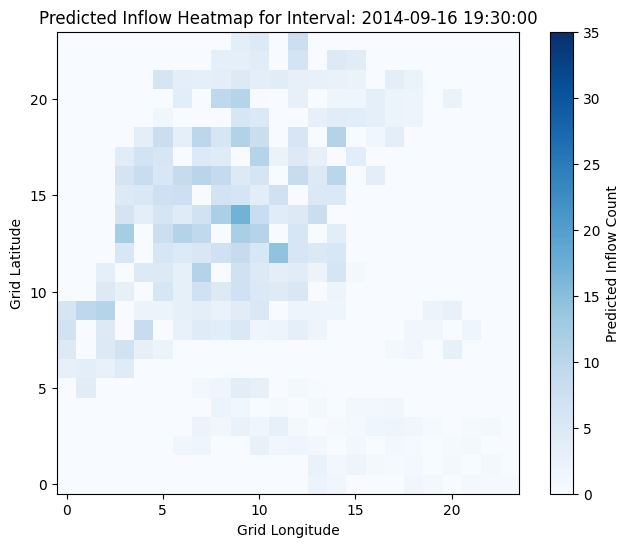

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 247   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=35, origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

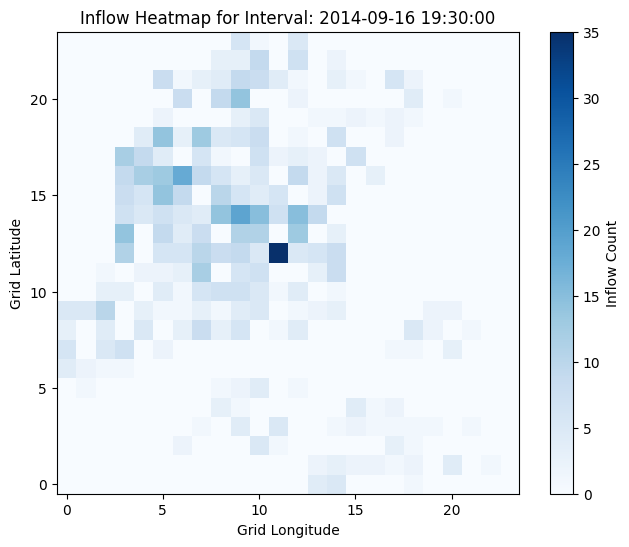

In [ ]:
example_test_interval_9 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_9], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_9}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

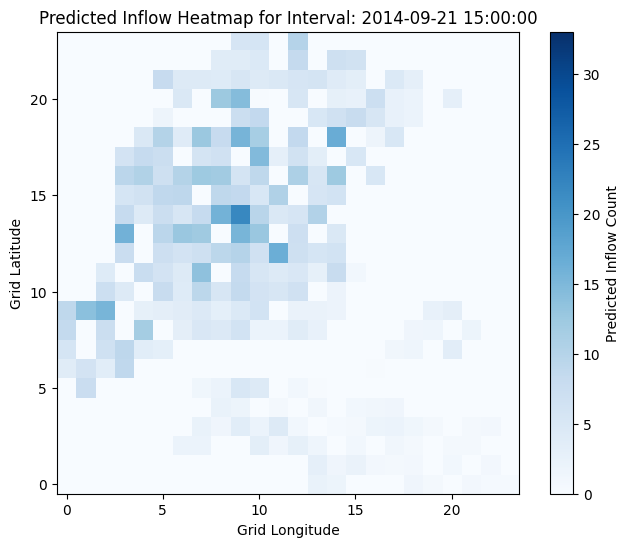

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 478   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=33, origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

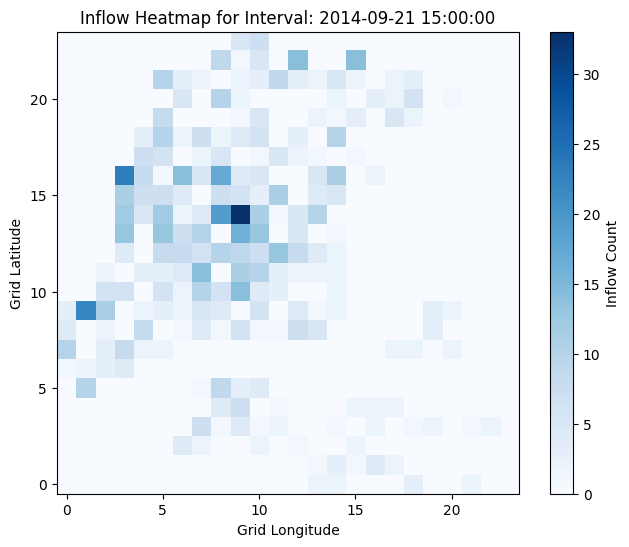

In [ ]:
example_test_interval_10 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_10], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_10}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

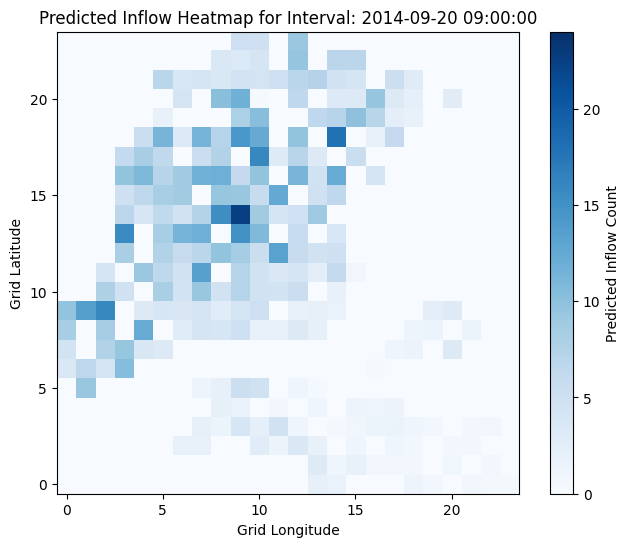

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 418   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=24, origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

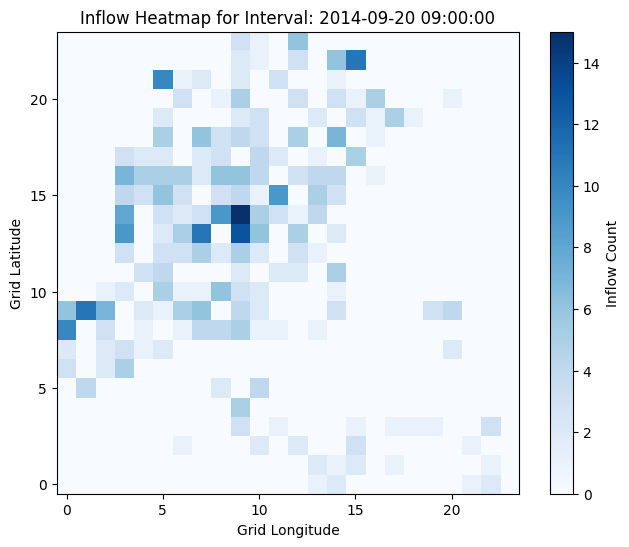

In [ ]:
example_test_interval_11 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_11], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_11}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

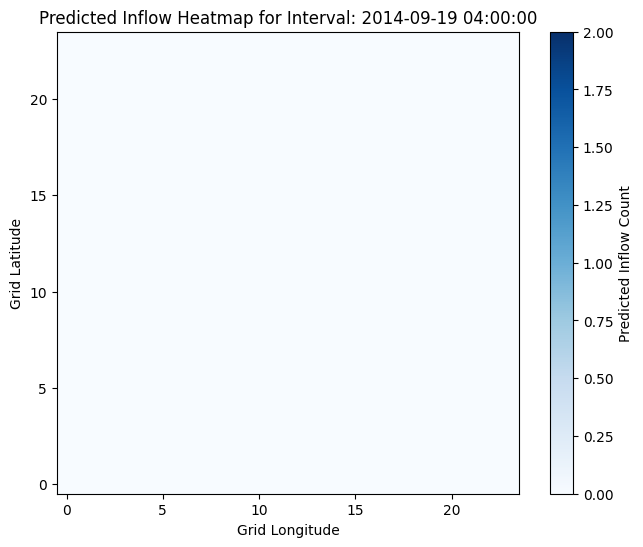

In [ ]:
# Select a specific timestep (forecast horizon)
timestep = 360   # Choose the timestep (0 to 47 for 48 timesteps)

# Extract predicted values for the selected timestep
# Shape of all_preds: (n_samples, 576, 48)
predicted_inflow = all_preds[:, :, timestep]  # Shape: (n_samples, 576)

# Select a specific sample (e.g., the first sample in the test set)
sample_index = 0
heatmap_data = predicted_inflow[sample_index].reshape(24, 24)  # Reshape to 24x24 grid

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap_data, cmap="Blues", vmin=0, vmax=2, origin="lower")
plt.colorbar(label="Predicted Inflow Count")
plt.title(f"Predicted Inflow Heatmap for Interval: {get_realtime_from_timestep(inflow_dict, timestep)}")
plt.xlabel("Grid Longitude")
plt.ylabel("Grid Latitude")
plt.show()

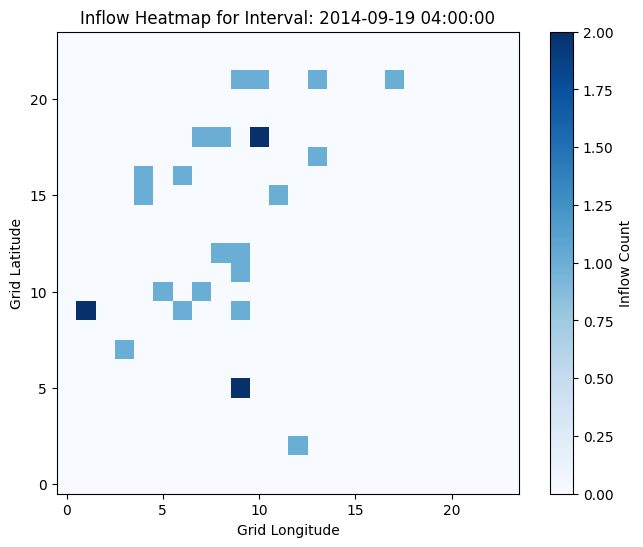

In [ ]:
example_test_interval_12 = list(inflow_dict.keys())[timestep+7856]
# Print inflow Heatmap
plt.figure(figsize=(8, 6))
plt.imshow(inflow_dict[example_test_interval_12], cmap='Blues', origin='lower')
plt.colorbar(label='Inflow Count')
plt.title(f'Inflow Heatmap for Interval: {example_test_interval_12}')
plt.xlabel('Grid Longitude')
plt.ylabel('Grid Latitude')
plt.show()

NYC_BIKE-3 data

In [ ]:
model_short_2020 = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs={
        'task_name': 'forecasting',
        'forecast_horizon': 48,
        'head_dropout': 0.1,
        'weight_decay': 0,
        'freeze_encoder': True, # Freeze the patch embedding layer
        'freeze_embedder': True, # Freeze the transformer encoder
        'freeze_head': False, # The linear forecasting head must be trained
    },
    # local_files_only=True,  # Whether or not to only look at local files (i.e., do not try to download the model).
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/951 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

In [ ]:
model_short_2020.init()
print(model_short_2020)

MOMENTPipeline(
  (normalizer): RevIN()
  (tokenizer): Patching()
  (patch_embedding): PatchEmbedding(
    (value_embedding): Linear(in_features=8, out_features=1024, bias=False)
    (position_embedding): PositionalEmbedding()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
  

/usr/local/lib/python3.10/dist-packages/momentfm/models/moment.py:174: UserWarning: Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.
  warnings.warn("Only reconstruction head is pre-trained. Classification and forecasting heads must be fine-tuned.")


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Define context length, forecast horizon, and batch size
context_length = 512  # Number of timesteps used as input
forecast_horizon = 48  # Number of timesteps to predict
batch_size = 4  # Number of sequences in each batch

# Split data into training (April–August) and testing (September)
train_ratio=0.8
total_data_samples = data.shape[0]
train_size = int(total_data_samples * train_ratio)  # 80% for training
test_size = total_data_samples - train_size         # 20% for testing

train_data = data[:train_size]
test_data = data[train_size:]

# Prepare training data: split into timeseries and forecast
train_timeseries = []
train_forecast = []

for i in range(0, train_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for training
    train_timeseries.append(torch.tensor(train_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for training
    train_forecast.append(torch.tensor(train_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert training data to tensors
train_timeseries = torch.stack(train_timeseries)  # Shape: (n_samples, 512, 1, 576)
train_forecast = torch.stack(train_forecast)  # Shape: (n_samples, 48, 1, 576)

# Create input mask for training
train_mask = torch.ones(train_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create training TensorDataset and DataLoader
train_dataset = TensorDataset(train_timeseries, train_forecast, train_mask)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Prepare testing data: split into timeseries and forecast
test_timeseries = []
test_forecast = []

for i in range(0, test_data.shape[0] - context_length - forecast_horizon, forecast_horizon):
    # Input sequence for testing
    test_timeseries.append(torch.tensor(test_data[i:i + context_length], dtype=torch.float32))  # Shape: (512, 1, 576)

    # Ground truth forecast for testing
    test_forecast.append(torch.tensor(test_data[i + context_length:i + context_length + forecast_horizon], dtype=torch.float32))  # Shape: (48, 1, 576)

# Convert testing data to tensors
test_timeseries = torch.stack(test_timeseries)  # Shape: (n_samples, 512, 1, 576)
test_forecast = torch.stack(test_forecast)  # Shape: (n_samples, 48, 1, 576)

# Create input mask for testing
test_mask = torch.ones(test_timeseries.shape[:2], dtype=torch.float32)  # Shape: (n_samples, 512)

# Create testing TensorDataset and DataLoader
test_dataset = TensorDataset(test_timeseries, test_forecast, test_mask)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)  # No shuffling for evaluation

# Print dataset info
print(f"Training Timeseries shape: {train_timeseries.shape}")
print(f"Training Forecast shape: {train_forecast.shape}")
print(f"Number of training batches: {len(train_loader)}")
print(f"Testing Timeseries shape: {test_timeseries.shape}")
print(f"Testing Forecast shape: {test_forecast.shape}")
print(f"Number of testing batches: {len(test_loader)}")


Training Timeseries shape: torch.Size([282, 512, 540])
Training Forecast shape: torch.Size([282, 48, 540])
Number of training batches: 71
Testing Timeseries shape: torch.Size([62, 512, 540])
Testing Forecast shape: torch.Size([62, 48, 540])
Number of testing batches: 16


In [ ]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to the appropriate device
model_short_2020 = model_short_2020.to(device)

# Define loss function and optimizer
criterion = torch.nn.MSELoss()  # Mean Squared Error loss
optimizer = torch.optim.Adam(model_short_2020.parameters(), lr=1e-4)  # Learning rate = 0.0001

for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(train_loader):
    # Move data to the device
    batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 576)
    batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 576)
    batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

    # Reshape timeseries for the model
    input_tensor = batch_timeseries.permute(0, 2, 1)  # Shape: (batch_size, 576, 512)

    # Forward pass
    with torch.cuda.amp.autocast():
        output = model_short_2020(x_enc=input_tensor, input_mask=batch_mask)

    # Reshape forecast to match model output
    batch_forecast = batch_forecast.permute(0, 2, 1)  # Shape: (batch_size, 576, 48)

    # Compute loss
    loss = criterion(output.forecast, batch_forecast)

    # Backward pass, optimizer step, etc.
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Print progress
    print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")


<ipython-input-31-b1490dd6690d>:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Batch 1/71: Loss = 39.09381103515625
Batch 2/71: Loss = 15.555356979370117
Batch 3/71: Loss = 20.83928680419922
Batch 4/71: Loss = 20.980817794799805
Batch 5/71: Loss = 20.6374568939209
Batch 6/71: Loss = 21.674518585205078
Batch 7/71: Loss = 17.37230110168457
Batch 8/71: Loss = 16.644025802612305
Batch 9/71: Loss = 21.496780395507812
Batch 10/71: Loss = 14.914772987365723
Batch 11/71: Loss = 22.39053726196289
Batch 12/71: Loss = 12.990068435668945
Batch 13/71: Loss = 16.148305892944336
Batch 14/71: Loss = 18.885988235473633
Batch 15/71: Loss = 12.8590087890625
Batch 16/71: Loss = 14.93571662902832
Batch 17/71: Loss = 15.584345817565918
Batch 18/71: Loss = 9.573681831359863
Batch 19/71: Loss = 15.812596321105957
Batch 20/71: Loss = 7.75431489944458
Batch 21/71: Loss = 18.079242706298828
Batch 22/71: Loss = 17.268489837646484
Batch 23/71: Loss = 24.351484298706055
Batch 24/71: Loss = 14.128091812133789
Batch 25/71: Loss = 17.49267578125
Batch 26/71: Loss = 17.827322006225586
Batch 27/71

In [ ]:
pprint(output)

Pretty printing has been turned OFF


In [ ]:
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

In [ ]:
# Set the model to evaluation mode
model_short_2020.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 540)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 540)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 540, 512)

        # Forward pass
        output = model_short_2020(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 540, 48)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 540, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 540, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")


Test Loss (MSE): 15.4111
Test MSE: 15.7077 | Test MAE: 0.8274


/usr/local/lib/python3.10/dist-packages/momentfm/utils/forecasting_metrics.py:49: RuntimeWarning: divide by zero encountered in divide
  div = a / b


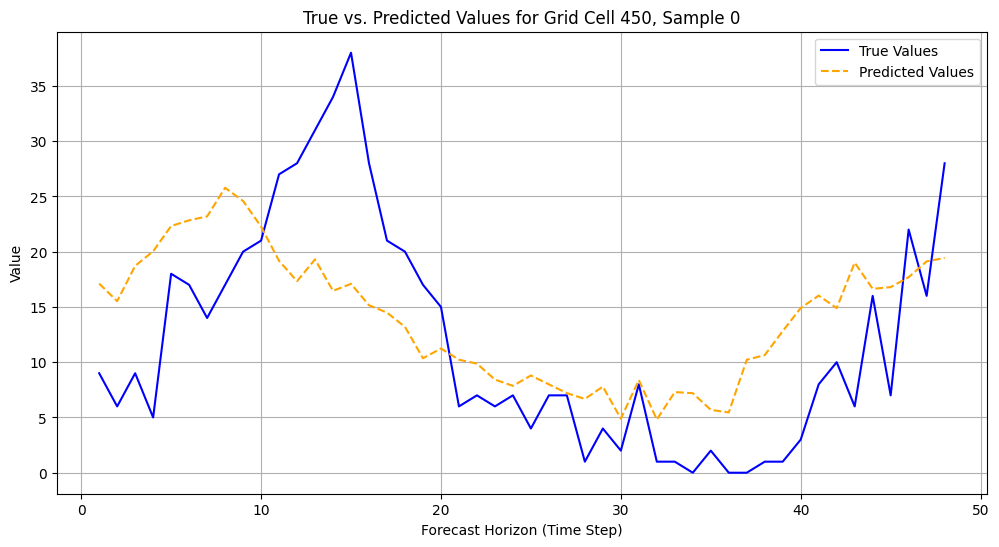

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 450  # Choose a grid cell index (0 to 540 for 540 grids)

# Extract true and predicted values for all 48 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 48)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 48)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

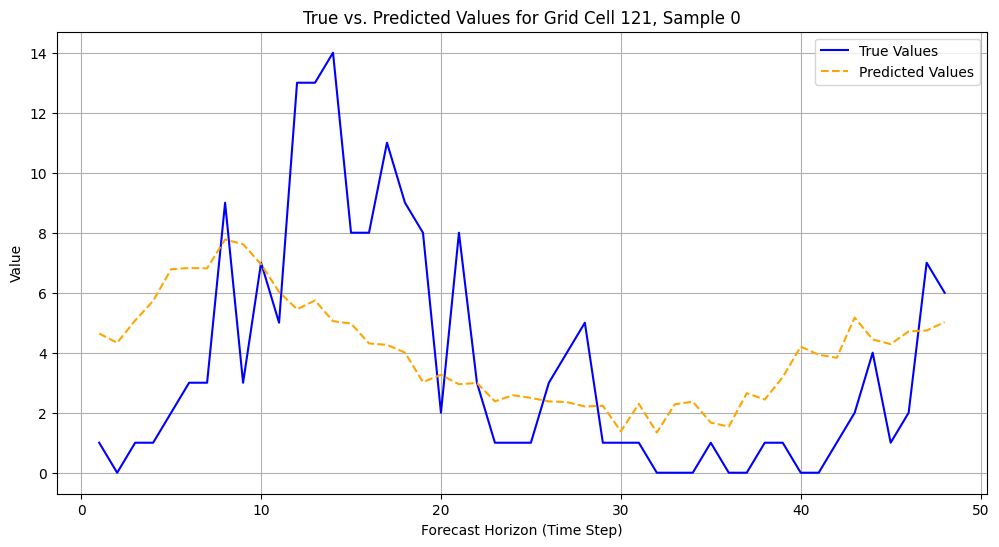

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 121 # Choose a grid cell index (0 to 540 for 540 grids)

# Extract true and predicted values for all 48 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 48)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 48)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

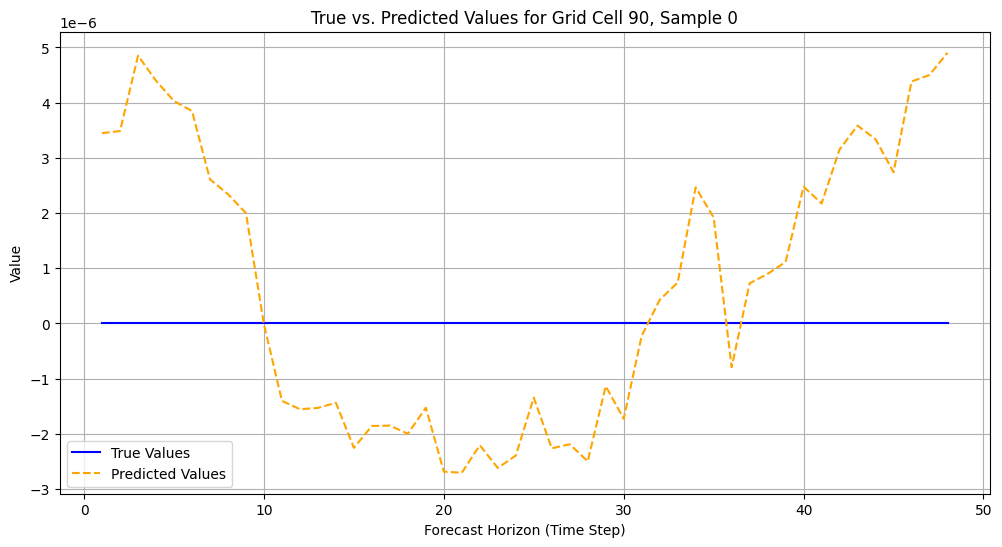

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 90 # Choose a grid cell index (0 to 540 for 540 grids)

# Extract true and predicted values for all 48 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 48)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 48)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_values, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_values, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

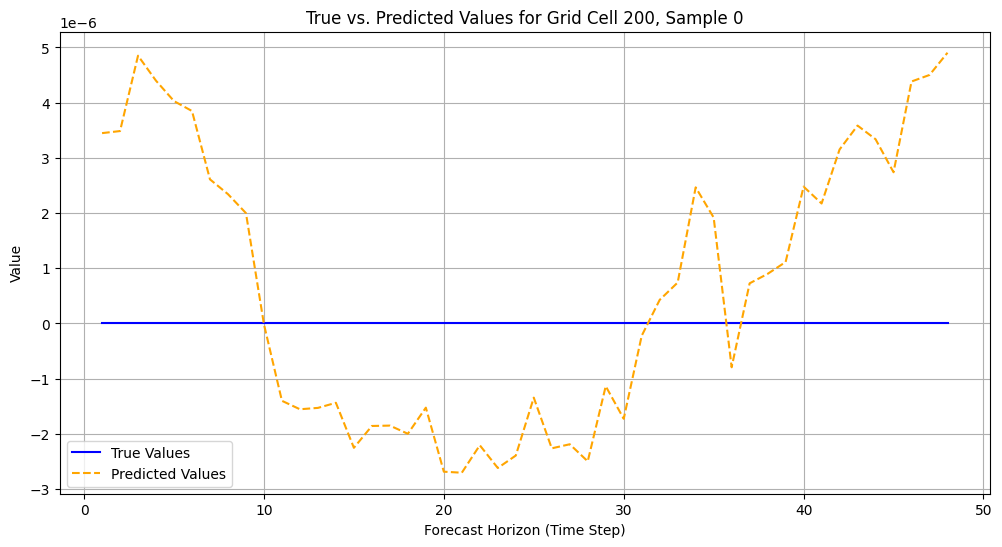

In [ ]:
# Select a specific grid cell to visualize
grid_cell = 200  # Choose a grid cell index (0 to 540 for 540 grids)

# Extract true and predicted values for all 48 timesteps
true_values = all_trues[:, grid_cell, :]  # Shape: (n_samples, 48)
predicted_values = all_preds[:, grid_cell, :]  # Shape: (n_samples, 48)

# Select a sample index to plot (e.g., the first sample in the test set)
sample_index = 0  # Choose the sample index
true_sample = true_values[sample_index]  # Shape: (48,)
predicted_sample = predicted_values[sample_index]  # Shape: (48,)

# Plot true vs. predicted values for all 480 timesteps
plt.figure(figsize=(12, 6))
plt.plot(range(1, 49), true_sample, label="True Values", color="blue", linestyle="-")
plt.plot(range(1, 49), predicted_sample, label="Predicted Values", color="orange", linestyle="--")
plt.xlabel("Forecast Horizon (Time Step)")
plt.ylabel("Value")
plt.title(f"True vs. Predicted Values for Grid Cell {grid_cell}, Sample {sample_index}")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Set the model to evaluation mode
model_short_2020.eval()

# Initialize variables to store test results
test_losses = []
all_trues = []
all_preds = []

# Disable gradient computation
with torch.no_grad():
    for batch_idx, (batch_timeseries, batch_forecast, batch_mask) in enumerate(test_loader):
        # Move data to the appropriate device
        batch_timeseries = batch_timeseries.float().to(device)  # Shape: (batch_size, 512, 1, 540)
        batch_forecast = batch_forecast.float().to(device)  # Shape: (batch_size, 48, 1, 540)
        batch_mask = batch_mask.to(device)  # Shape: (batch_size, 512)

        # Reshape input tensor for the model
        input_tensor = batch_timeseries.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 540, 512)

        # Forward pass
        output = model_short_2020(x_enc=input_tensor, input_mask=batch_mask)  # Model output

        # Reshape forecast to match model output
        batch_forecast = batch_forecast.squeeze(2).permute(0, 2, 1)  # Shape: (batch_size, 540, 48)

        # Compute loss
        loss = criterion(output.forecast, batch_forecast)
        test_losses.append(loss.item())

        # Store true and predicted values for evaluation
        all_trues.append(batch_forecast.cpu().numpy())
        all_preds.append(output.forecast.detach().cpu().numpy())

# Compute average test loss
average_test_loss = sum(test_losses) / len(test_losses)
print(f"Test Loss (MSE): {average_test_loss:.4f}")

# Combine true and predicted values for metric computation
all_trues = np.concatenate(all_trues, axis=0)  # Shape: (n_samples, 540, 48)
all_preds = np.concatenate(all_preds, axis=0)  # Shape: (n_samples, 540, 48)

# Compute additional forecasting metrics
metrics = get_forecasting_metrics(y=all_trues, y_hat=all_preds, reduction="mean")
print(f"Test MSE: {metrics.mse:.4f} | Test MAE: {metrics.mae:.4f}")
